(mmm_geolift_calibration)=

# MMM Calibration with Geo-Level Lift Tests

## Introduction

This notebook demonstrates how to calibrate a multidimensional MMM using lift test results from a geo-level experiment. By incorporating experimental lift measurements, we can achieve better parameter recovery--both reduced bias and increased precision--compared to fitting the MMM alone.

We follow the same pattern as the {ref}`mmm_lift_test` notebook, generating data directly from the model to ensure perfect consistency.

:::{admonition} Prerequisites
:class: tip

Before working through this notebook, we recommend familiarity with:

- **{ref}`mmm_lift_test`**: Introduces the core concepts of lift test calibration in a simpler single-geo setting. Start here if you're new to MMM calibration.
- **{ref}`mmm_multidimensional_example`**: Covers geo-level modeling basics, including how to specify dimensions and hierarchical priors.
- **[CausalPy Multi-Cell GeoLift](https://causalpy.readthedocs.io/en/latest/notebooks/multi_cell_geolift.html)**: Shows how to analyze geo-level experiments using synthetic control to obtain the `delta_y` estimates used in this notebook.
:::

### Notebook Overview

This is a long technical document, so here's a roadmap of what we'll cover:

**Setup (Sections 1-2)**
- We simulate a marketing dataset with **8 geographic regions** and **2 media channels**
- The two channels are highly correlated (~0.99), making them difficult to separate--a common real-world challenge

**The Experiment (Section 3)**
- We run a geo-level lift test on **channel 1 only**
- **4 treated geos** receive an incremental spend increase; **4 control geos** remain unchanged
- This produces **4 lift test measurements**--one per treated geo--each estimating the causal effect of channel 1

**Analysis (Sections 4-6)**
- We fit the MMM twice: once without calibration (baseline) and once with lift test calibration
- We compare parameter recovery, showing that calibration reduces bias and increases precision
- Key result: the calibrated model's saturation curves more closely match the true curves

### When to Use Geo-Level Lift Tests

Geo-level lift tests are appropriate when you can:
- **Target specific geographic regions**: Digital campaigns with location targeting, regional TV markets
- **Hold out control regions**: Some geos receive the treatment while others serve as controls
- **Measure regional outcomes**: Sales, conversions, or other metrics at the geographic level

### The Practical Workflow: From Experiment to Calibration

In practice, running a geo-level lift test and using it to calibrate an MMM involves several steps:

1. **Design and run the experiment**: Increase (or decrease) spend on one channel in a subset of geographic regions (treated geos), while keeping spend unchanged in the remaining regions (control geos). Run the experiment for several weeks.

2. **Analyze the experiment with synthetic control**: Use a method like [CausalPy's multi-cell GeoLift](https://causalpy.readthedocs.io/en/latest/notebooks/multi_cell_geolift.html) to estimate the causal effect. Synthetic control constructs a weighted combination of control geos that matches each treated geo's pre-experiment trend, then measures the post-experiment divergence as the treatment effect.

3. **Extract lift test measurements**: From the CausalPy analysis, obtain for each treated geo:
   - x: the baseline spend level during the test period
   - delta_x: the incremental spend change applied
   - delta_y: the estimated causal lift in outcomes
   - sigma: the uncertainty (standard error) of the lift estimate

4. **Calibrate the MMM**: Pass these lift test measurements to the MMM's add_lift_test_measurements() method to constrain the saturation curve parameters during model fitting.

**Scope of this notebook**: This notebook focuses on step 4--demonstrating how lift test measurements improve MMM parameter recovery. We simulate the lift test results directly rather than running a full CausalPy analysis, since this is a PyMC-Marketing tutorial. For the experiment analysis step, see the [CausalPy documentation](https://causalpy.readthedocs.io/en/latest/notebooks/multi_cell_geolift.html).

### Why Lift Tests Work: Pinning Down the Saturation Curve

It's worth understanding *why* lift tests improve parameter estimation--the benefit goes beyond simply adding more variation to your data.

**The problem with observational data alone**

When fitting an MMM to observational data, you observe spend (X) and outcomes (Y) moving together. But correlation isn't causation:
- Maybe sales rise when spend rises because the spend *caused* more sales
- Or maybe both rose because of an external factor (seasonality, promotions, economic conditions)
- With highly correlated channels, the model can't tell which channel is actually driving sales--many different parameter combinations fit the data equally well

**What a lift test provides: causal ground truth**

A lift test is an *experiment*. By randomly assigning some geos to receive increased spend while others serve as controls, the difference in outcomes between groups is a **causal effect**, not just a correlation. The lift test tells you:

> "When we increased channel 1 spend from x to x + delta_x, the true causal lift in sales was delta_y"

This is a point on the saturation curve that we *know* to be correct, not just inferred from correlational patterns.

**How calibration uses this information**

When we add lift test measurements to the MMM, we're adding a constraint that says: the model's saturation curve must pass through (or near) the experimentally measured point. Mathematically:

$$\text{saturation}(x + \Delta x) - \text{saturation}(x) \approx \Delta y$$

This pins down the saturation curve at the operating point where the experiment was run, dramatically reducing the set of feasible (lambda, beta) parameter values.

**The key distinction**

| Aspect | More Spend Variation | Lift Test Calibration |
|--------|----------------------|----------------------|
| **Provides** | More data points | Causal ground truth |
| **Helps with** | Precision (narrower posteriors) | Accuracy (reduced bias) |
| **Addresses** | Uncertainty in parameters | Bias in parameters |

In short: more data variation helps you estimate parameters more precisely, but a lift test helps you estimate the *right* parameters.

### How Hierarchical Priors Enable Information Flow

The hierarchical prior structure is key to understanding how geo-level lift tests improve the entire model, not just the tested geos.

**The Mechanism:**

1. **Direct calibration of treated geos**: Lift tests in treated geos directly constrain those geos' saturation parameters to match the experimentally observed effect.

2. **Information flows to population parameters**: When the model learns that treated geos have certain λ/β values, it updates the *population-level* parameters (μ and σ) that generated them.

3. **Population parameters inform control geos**: The updated population parameters then provide better priors for the *untested* control geos, even though they weren't directly calibrated.

**Why This Matters:**

| Geo Type | Without Hierarchical Priors | With Hierarchical Priors |
|----------|----------------------------|--------------------------|
| Treated geos | Directly calibrated | Directly calibrated |
| Control geos | No benefit from lift tests | Indirectly calibrated via population |

This is the essence of **partial pooling**: information from the experiment propagates across all geos through the shared population distribution. The more geos you test, the better the population parameters become, and the more all geos benefit.

### Key Design Principles

1. **Normalized data**: Channel spend is normalized to [0, 1] range for consistent saturation behavior
2. **Model-based data generation**: We use `pm.do` and `pm.draw` to generate synthetic data from the model itself, ensuring the data perfectly matches model assumptions
3. **Consistent lift tests**: Lift test measurements are calculated using the same saturation function the model uses

## Prepare Notebook

In [1]:
from functools import partial

import arviz as az
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
import xarray as xr
from pymc_extras.prior import Prior

from pymc_marketing.mmm import GeometricAdstock, LogisticSaturation
from pymc_marketing.mmm.multidimensional import MMM
from pymc_marketing.mmm.transformers import logistic_saturation

plt.style.use("bmh")
plt.rcParams["figure.figsize"] = (12, 7)
plt.rcParams["figure.dpi"] = 100
az.style.use("arviz-darkgrid")
%config InlineBackend.figure_format = "retina"
plt.rcParams.update({"figure.constrained_layout.use": True})


def format_date_axis(ax):
    """Apply concise date formatting to a matplotlib axis."""
    locator = mdates.AutoDateLocator()
    formatter = mdates.ConciseDateFormatter(locator)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
# Set random seed for reproducibility
seed = sum(map(ord, "Geo lift tests for MMM calibration"))
rng = np.random.default_rng(seed)
print(f"Random seed: {seed}")

Random seed: 3155


## Generate Synthetic Data

Our data generation follows a two-step process that ensures perfect consistency between the synthetic data and model assumptions:

### Step 1: Manually Simulate Channel Spend (X)

We manually create the **input data** — the marketing spend decisions:
- `channel_1`, `channel_2`: Normalized spend values in [0, 1] range
- `date`: Time dimension (weekly data)
- `geo`: Geographic dimension

This represents **business decisions** that are external to the model. We intentionally create highly correlated channels to simulate the identification problem that lift tests help solve.

**Importantly, the lift test experiment is embedded in the data**: During the final 8 weeks (the experiment period), the 4 treated geos receive increased channel 1 spend. This mirrors what would happen in a real geo-level experiment.

### Step 2: Generate Outcomes from the Model (y)

We generate the **target variable** (sales/conversions) using `pm.do` and `pm.draw`:
1. Build the MMM with the spend data X (which includes the experiment)
2. Use `pm.do` to fix model parameters to known "true" values
3. Use `pm.draw` to sample y from the model

This approach ensures that y is generated **exactly as the model expects**, including:
- Adstock transformations applied correctly
- Saturation curves computed consistently
- Noise structure matching the model's likelihood
- Internal scaling handled properly
- **The causal effect of the experiment on outcomes** (treated geos will have higher y during the experiment period due to increased channel 1 spend)

**Why not generate y manually?** Manual generation (e.g., `y = intercept + beta * saturation(adstock(x)) + noise`) can introduce subtle mismatches with how the model actually computes predictions, leading to poor parameter recovery.

---

### Create Normalized Channel Spend Data

Following the national-level notebook, we normalize spend data to [0, 1] range. This ensures:
- Saturation parameters (lam) have intuitive values (e.g., 2-8)
- The model's internal scaling doesn't create mismatches
- Lift test measurements are consistent with model assumptions

In [3]:
# Define dimensions
n_dates = 104  # 2 years of weekly data
geos = [f"geo_{i:02d}" for i in range(8)]  # 8 geos for tractable computation
n_geos = len(geos)
channels = ["channel_1", "channel_2"]
n_channels = len(channels)

# Create date range
dates = pd.date_range(start="2022-01-03", periods=n_dates, freq="W-MON")

# Define lift test experiment parameters
# The experiment runs for the last 8 weeks of the dataset
experiment_weeks = 8
experiment_start_idx = n_dates - experiment_weeks
experiment_start_date = dates[experiment_start_idx]
experiment_end_date = dates[-1]

# Treatment assignment: alternating geos for balance
treated_geos = [geos[i] for i in [0, 2, 4, 6]]  # 4 treated geos
control_geos = [geos[i] for i in [1, 3, 5, 7]]  # 4 control geos
test_channel = "channel_1"

# Spend increase during experiment (on normalized 0-1 scale)
# This is the incremental spend applied to treated geos
delta_x_experiment = 0.15

In [4]:
print("Data dimensions:")
print(f"  Dates: {n_dates} weeks ({dates[0].date()} to {dates[-1].date()})")
print(f"  Geos: {n_geos}")
print(f"  Channels: {n_channels}")
print("\nLift test experiment:")
print(
    f"  Period: {experiment_start_date.date()} to {experiment_end_date.date()} ({experiment_weeks} weeks)"
)
print(f"  Test channel: {test_channel}")
print(f"  Treated geos: {treated_geos}")
print(f"  Control geos: {control_geos}")
print(f"  Spend increase (delta_x): {delta_x_experiment}")

Data dimensions:
  Dates: 104 weeks (2022-01-03 to 2023-12-25)
  Geos: 8
  Channels: 2

Lift test experiment:
  Period: 2023-11-06 to 2023-12-25 (8 weeks)
  Test channel: channel_1
  Treated geos: ['geo_00', 'geo_02', 'geo_04', 'geo_06']
  Control geos: ['geo_01', 'geo_03', 'geo_05', 'geo_07']
  Spend increase (delta_x): 0.15


In [5]:
# Generate normalized spend data (0-1 range)
# Channel 1 and 2 are highly correlated (the identification problem)
rows = []

for geo in geos:
    # Generate base spend pattern (shared across channels for correlation)
    base_spend = pm.draw(
        pm.Uniform.dist(lower=0.2, upper=1.0, size=n_dates), random_seed=rng
    )
    base_spend = base_spend / base_spend.max()  # Normalize to max=1

    # Add geo-specific scaling
    geo_scale = 0.7 + 0.3 * (geos.index(geo) / (n_geos - 1))  # 0.7 to 1.0

    # Check if this geo is in the treatment group
    is_treated = geo in treated_geos

    for i, date in enumerate(dates):
        # Channel 1: base pattern with small noise
        ch1 = base_spend[i] * geo_scale + rng.normal(0, 0.02)
        ch1 = np.clip(ch1, 0.1, 1.0)

        # Apply experiment: increase channel 1 spend in treated geos during experiment period
        if is_treated and i >= experiment_start_idx:
            ch1_baseline = ch1  # Store baseline for reference
            ch1 = ch1 + delta_x_experiment
            ch1 = np.clip(ch1, 0.1, 1.2)  # Allow slightly above 1.0 during experiment

        # Channel 2: highly correlated with channel 1 (shifted slightly)
        # Note: Channel 2 is NOT affected by the experiment
        ch2 = base_spend[i] * geo_scale * 0.95 + rng.normal(0, 0.02)
        ch2 = np.clip(ch2, 0.1, 1.0)

        rows.append(
            {
                "date": date,
                "geo": geo,
                "channel_1": ch1,
                "channel_2": ch2,
            }
        )

df = pd.DataFrame(rows)

# Verify normalization
print("Channel spend ranges:")
print(
    f"  Overall: channel_1=[{df['channel_1'].min():.3f}, {df['channel_1'].max():.3f}], "
    f"channel_2=[{df['channel_2'].min():.3f}, {df['channel_2'].max():.3f}]"
)

# Check experiment effect
experiment_mask = df["date"] >= experiment_start_date
treated_mask = df["geo"].isin(treated_geos)

pre_experiment_treated = df[~experiment_mask & treated_mask]["channel_1"].mean()
during_experiment_treated = df[experiment_mask & treated_mask]["channel_1"].mean()
during_experiment_control = df[experiment_mask & ~treated_mask]["channel_1"].mean()

print("\nExperiment verification (channel_1):")
print(f"  Pre-experiment (treated geos): {pre_experiment_treated:.3f}")
print(f"  During experiment (treated geos): {during_experiment_treated:.3f}")
print(f"  During experiment (control geos): {during_experiment_control:.3f}")
observed_increase = during_experiment_treated - pre_experiment_treated
print(
    f"  Observed spend increase: {observed_increase:.3f} (expected ~{delta_x_experiment})"
)

# Check correlation (excluding experiment period for fair comparison)
pre_exp_df = df[~experiment_mask]
corr = pre_exp_df[["channel_1", "channel_2"]].corr().iloc[0, 1]
print(
    f"\nChannel correlation (pre-experiment): {corr:.3f} (high correlation = identification challenge)"
)

Channel spend ranges:
  Overall: channel_1=[0.113, 1.106], channel_2=[0.117, 0.991]

Experiment verification (channel_1):
  Pre-experiment (treated geos): 0.488
  During experiment (treated geos): 0.606
  During experiment (control geos): 0.532
  Observed spend increase: 0.118 (expected ~0.15)

Channel correlation (pre-experiment): 0.990 (high correlation = identification challenge)


/var/folders/pd/p2qnky2x3xl4w3mgc4lct2200000gn/T/ipykernel_58742/1774918991.py:80: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


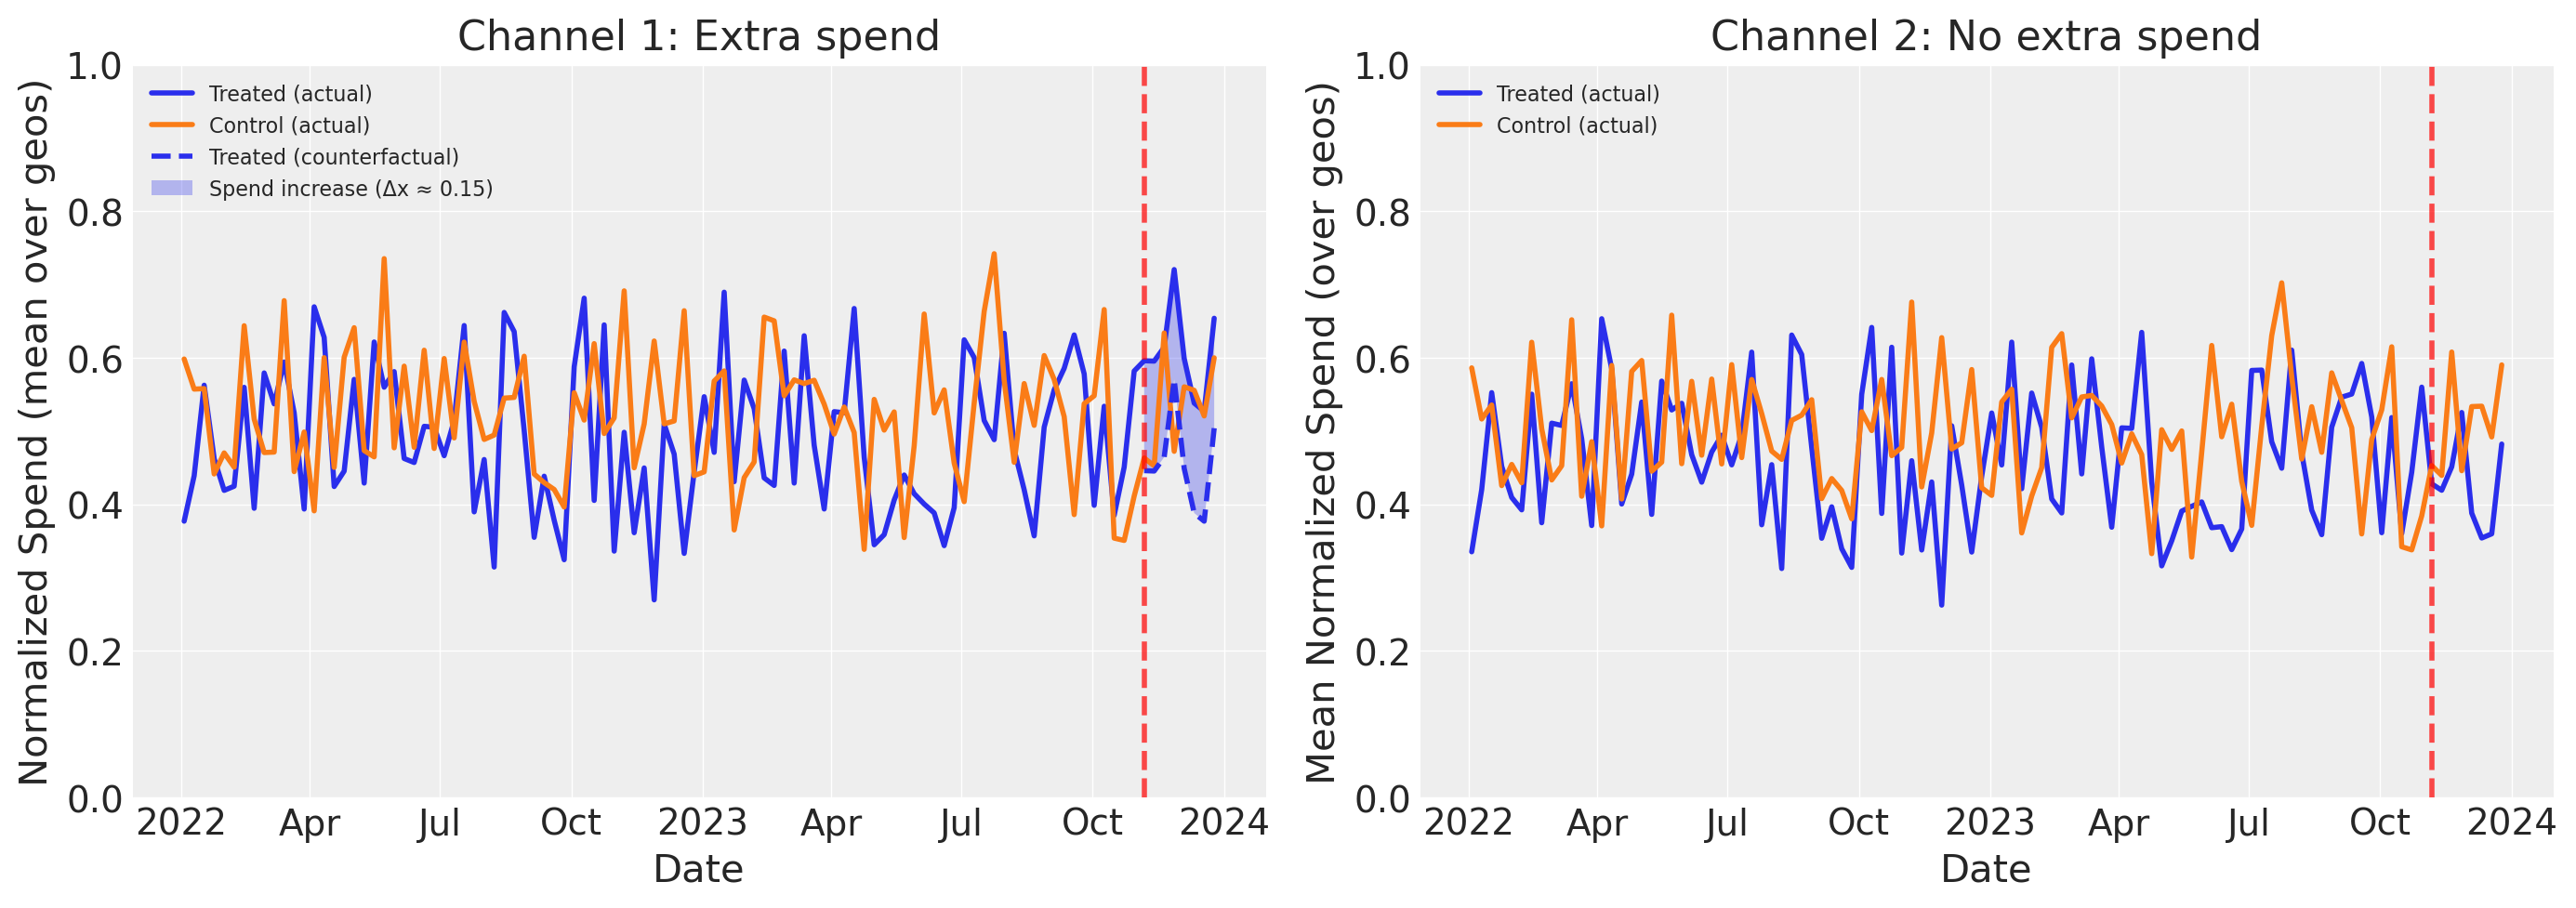

In [6]:
# Visualize spend patterns with experiment highlighted
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Add group label for seaborn
df["group"] = df["geo"].apply(lambda g: "Treated" if g in treated_geos else "Control")

# Derive counterfactual spend: what treated geos would have spent without the experiment
df["channel_1_counterfactual"] = df["channel_1"].copy()
mask = df["geo"].isin(treated_geos) & (df["date"] >= experiment_start_date)
df.loc[mask, "channel_1_counterfactual"] -= delta_x_experiment

# Plot 1: Actual spend (treated & control) + counterfactual for treated
ax = axes[0]
treated_df = df[df["geo"].isin(treated_geos)]
control_df = df[df["geo"].isin(control_geos)]
treated_actual_avg = treated_df.groupby("date")["channel_1"].mean()
control_actual_avg = control_df.groupby("date")["channel_1"].mean()
counterfactual_avg = treated_df.groupby("date")["channel_1_counterfactual"].mean()
ax.plot(
    treated_actual_avg.index,
    treated_actual_avg.values,
    label="Treated (actual)",
    linewidth=2,
)
ax.plot(
    control_actual_avg.index,
    control_actual_avg.values,
    label="Control (actual)",
    linewidth=2,
)
# Only show counterfactual from experiment start (before that, it's identical to actual)
cf_experiment = counterfactual_avg[counterfactual_avg.index >= experiment_start_date]
ax.plot(
    cf_experiment.index,
    cf_experiment.values,
    label="Treated (counterfactual)",
    linewidth=2,
    linestyle="--",
    color="C0",
)
ax.fill_between(
    cf_experiment.index,
    cf_experiment.values,
    treated_actual_avg[treated_actual_avg.index >= experiment_start_date].values,
    alpha=0.3,
    label=f"Spend increase (Δx ≈ {delta_x_experiment})",
)
ax.axvline(experiment_start_date, color="red", linestyle="--", linewidth=2, alpha=0.7)
ax.set_title("Channel 1: Extra spend")
ax.set_xlabel("Date")
ax.set_ylabel("Normalized Spend (mean over geos)")
ax.legend(loc="upper left", fontsize=8)
ax.set_ylim(0, 1)
format_date_axis(ax)

# Plot 2: Channel 2 spend (no experiment effect)
ax = axes[1]
treated_ch2_avg = treated_df.groupby("date")["channel_2"].mean()
control_ch2_avg = control_df.groupby("date")["channel_2"].mean()
ax.plot(
    treated_ch2_avg.index,
    treated_ch2_avg.values,
    label="Treated (actual)",
    linewidth=2,
)
ax.plot(
    control_ch2_avg.index,
    control_ch2_avg.values,
    label="Control (actual)",
    linewidth=2,
)
ax.axvline(experiment_start_date, color="red", linestyle="--", linewidth=2, alpha=0.7)
ax.set_title("Channel 2: No extra spend")
ax.set_xlabel("Date")
ax.set_ylabel("Mean Normalized Spend (over geos)")
ax.legend(loc="upper left", fontsize=8)
ax.set_ylim(0, 1)
format_date_axis(ax)

plt.tight_layout()
plt.show()

**Reading the plots above:**

The **left** panel shows the experiment's effect on Channel 1 spend. The solid lines show actual mean spend (averaged over geos) for treated and control groups. During the experiment period, the treated group's actual spend diverges upward from the dashed counterfactual line (what those geos would have spent without the intervention). The shaded area between them is the spend increase (`delta_x`). The control group continues its baseline pattern, unaffected by the experiment.

The **right** panel shows the same view for **Channel 2**, which was *not* manipulated during the experiment. Both treated and control geos follow similar spend patterns throughout, with no divergence during the experiment period. This confirms that the experiment only affected Channel 1--any difference in outcomes between treated and control geos can therefore be attributed to the Channel 1 spend increase, not to changes in Channel 2.

/var/folders/pd/p2qnky2x3xl4w3mgc4lct2200000gn/T/ipykernel_58742/1803005685.py:41: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


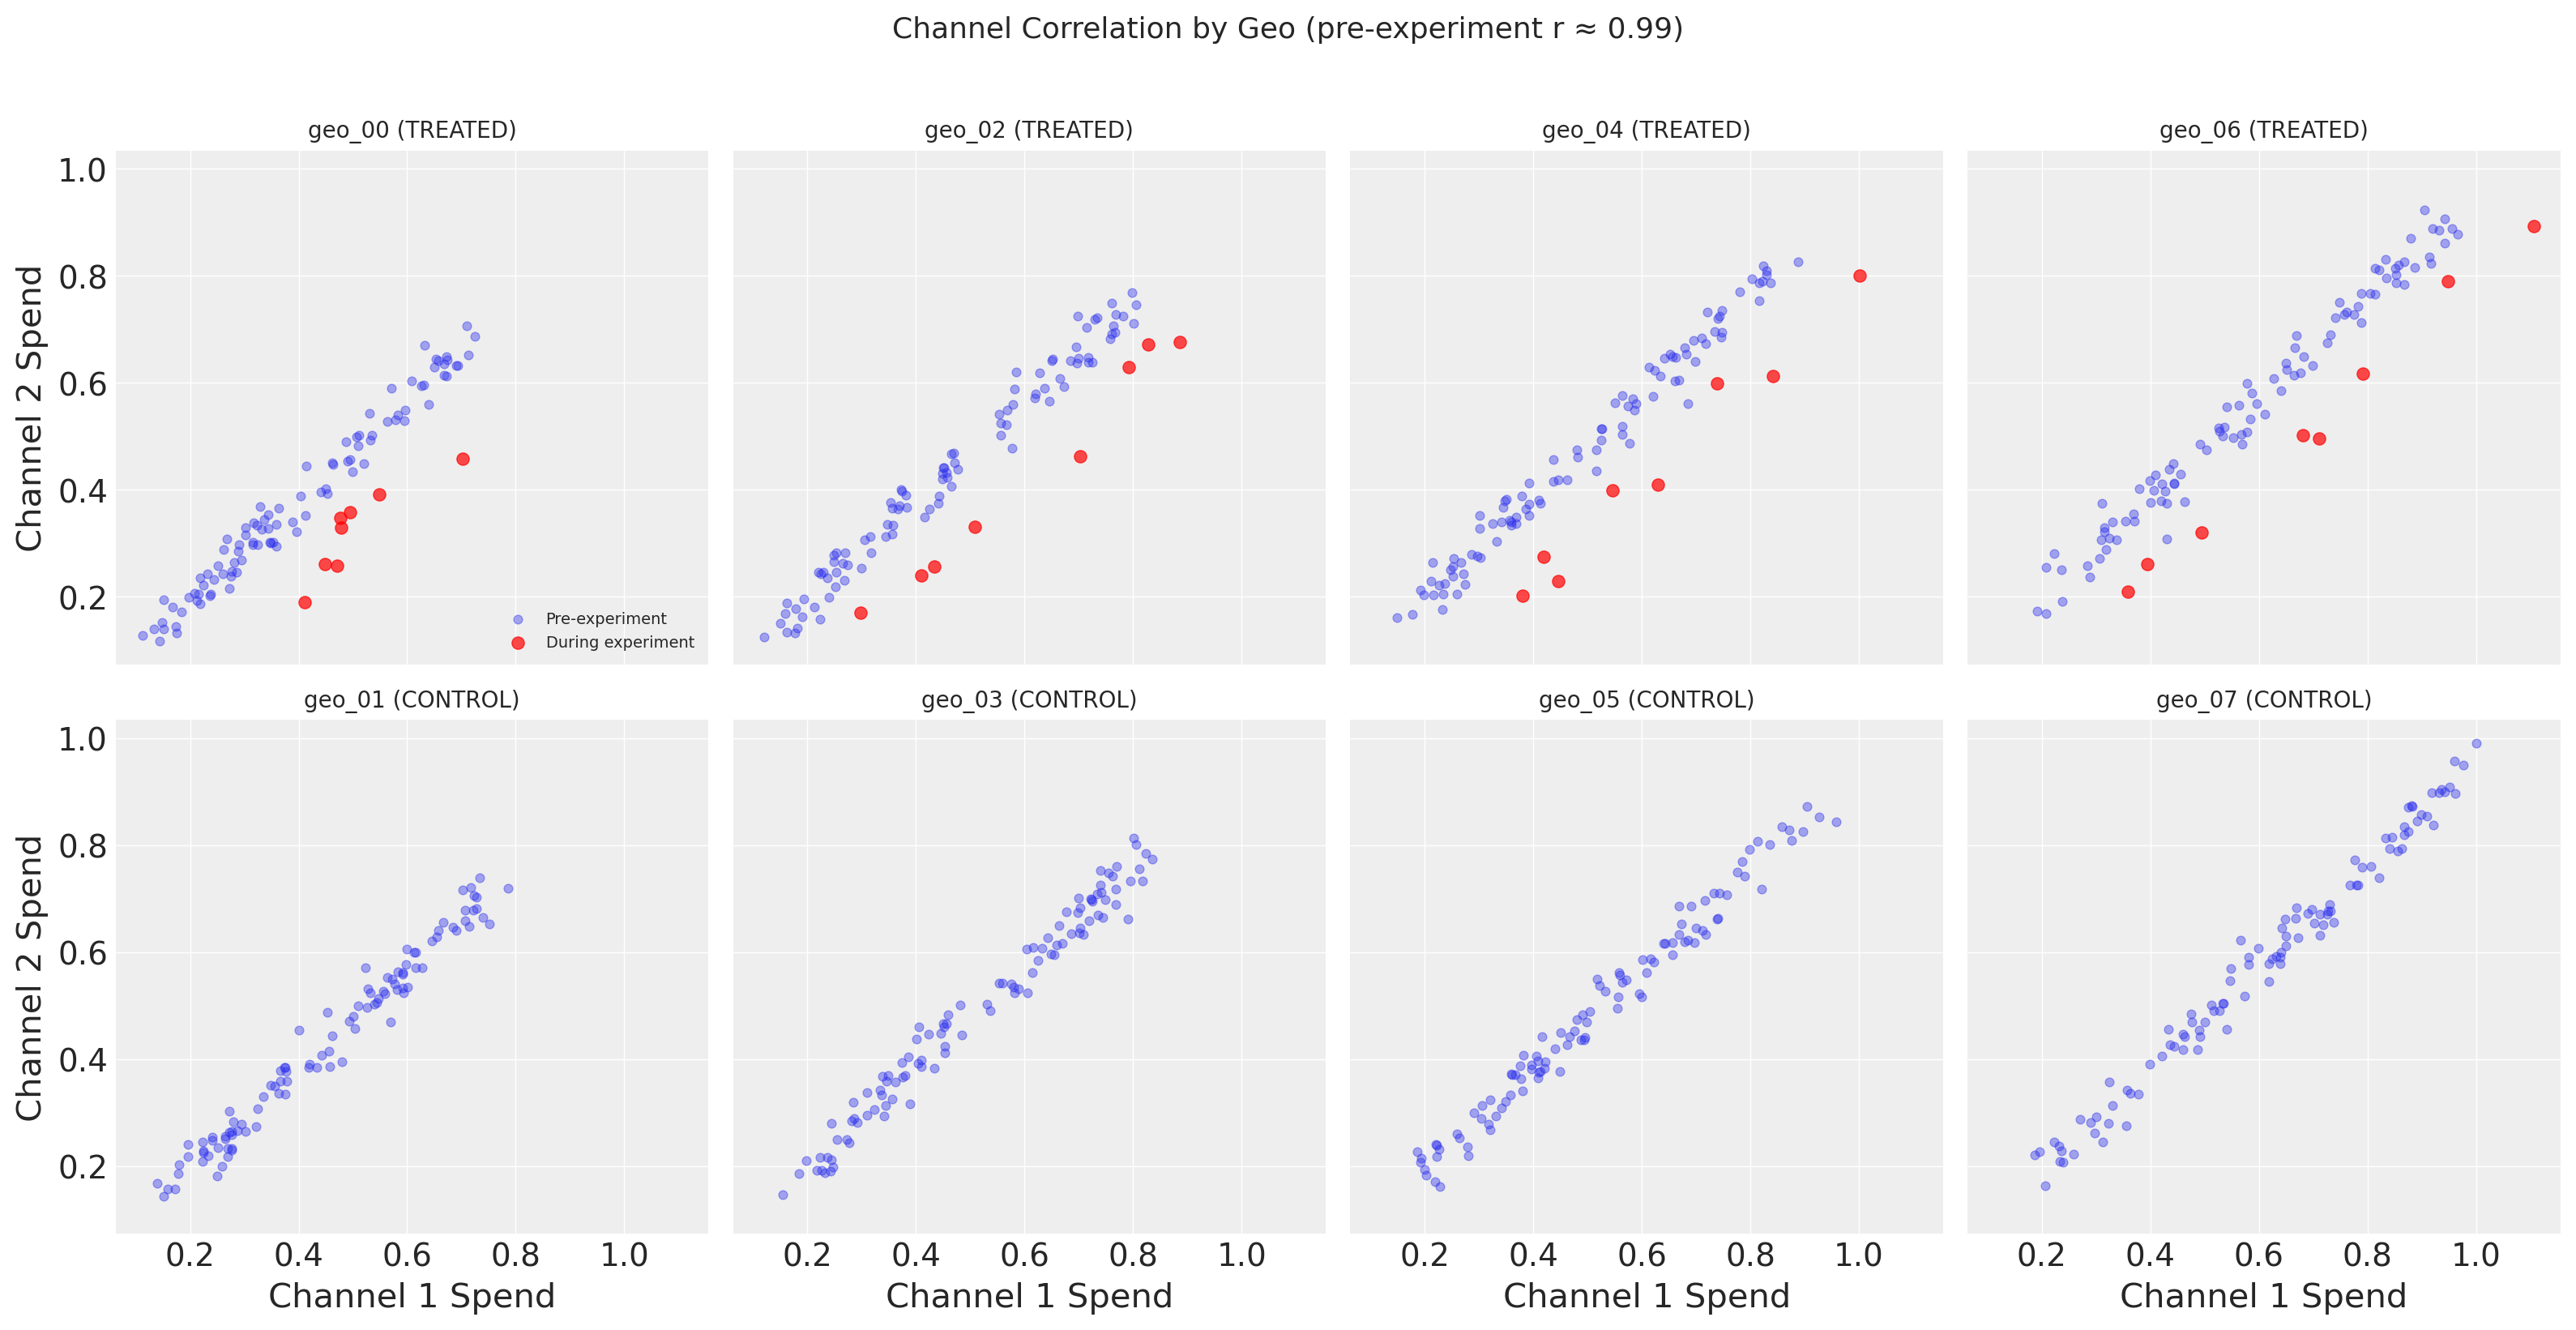

In [7]:
# Channel correlation by geo: treated (top row) vs control (bottom row)
fig, axes = plt.subplots(2, 4, figsize=(16, 8), sharex=True, sharey=True)

for col, geo in enumerate(treated_geos):
    ax = axes[0, col]
    geo_data = df[df["geo"] == geo]
    pre = geo_data[geo_data["date"] < experiment_start_date]
    post = geo_data[geo_data["date"] >= experiment_start_date]
    ax.scatter(
        pre["channel_1"], pre["channel_2"], alpha=0.4, s=15, label="Pre-experiment"
    )
    ax.scatter(
        post["channel_1"],
        post["channel_2"],
        alpha=0.7,
        s=30,
        color="red",
        label="During experiment",
    )
    ax.set_title(f"{geo} (TREATED)", fontsize=10)
    if col == 0:
        ax.set_ylabel("Channel 2 Spend")
        ax.legend(fontsize=7, loc="lower right")

for col, geo in enumerate(control_geos):
    ax = axes[1, col]
    geo_data = df[df["geo"] == geo]
    ax.scatter(
        geo_data["channel_1"], geo_data["channel_2"], alpha=0.4, s=15, color="C0"
    )
    ax.set_title(f"{geo} (CONTROL)", fontsize=10)
    if col == 0:
        ax.set_ylabel("Channel 2 Spend")
    ax.set_xlabel("Channel 1 Spend")

plt.suptitle(
    f"Channel Correlation by Geo (pre-experiment r ≈ {corr:.2f})",
    fontsize=13,
    y=1.02,
)
plt.tight_layout()
plt.show()

The figure above reveals the key challenge that motivates lift test calibration: **Channel 1 and Channel 2 spend are nearly perfectly correlated** in the observational data.

The **top row** shows treated geos, with pre-experiment points (blue) and during-experiment points (red) plotted separately. Before the experiment, each geo's spend follows a tight linear relationship between channels. During the experiment, the red points break away from this pattern--Channel 1 spend increases while Channel 2 stays the same, pulling the points rightward off the correlation line. This is precisely the experimental variation that enables causal identification.

The **bottom row** shows control geos, where all time points are plotted in a single color since nothing changed for these geos. The tight correlation holds throughout, confirming that the experiment did not affect control geos.

Without the experimental variation visible in the treated geos, the MMM cannot distinguish which channel is actually driving sales--many different parameter combinations fit the correlated data equally well. This additional spend variation alone helps with *precision* (narrower posteriors), but the lift test calibration we'll add later goes further: it adds a direct likelihood constraint on the saturation curve itself, encoding *causal* information that improves *accuracy* (reduced bias)--not just more data points.

### Define True Parameters with Geo-Level Heterogeneity

A key advantage of geo-level modeling is capturing **regional heterogeneity** in media response. Different markets may have different saturation characteristics due to:
- **Market maturity**: Established markets may saturate faster than emerging ones
- **Competition**: Competitive markets may require more spend to achieve the same effect
- **Demographics**: Different audience compositions respond differently to media

We model this heterogeneity using a **hierarchical structure**:
- Each geo has its own saturation parameters (lam, beta)
- These geo-level parameters are drawn from a common population distribution
- This allows **partial pooling**: information is shared across geos while allowing for regional differences

**True parameter structure** (for normalized [0, 1] spend data):
- **Saturation lam**: Population mean ~8 for channel 1, ~6 for channel 2, with geo-level variation (σ ≈ 1.0)
- **Saturation beta**: Population mean ~0.6 for channel 1, ~0.5 for channel 2, with geo-level variation (σ ≈ 0.08)
- **Adstock alpha**: Shared across geos (0.5 for both channels)

This hierarchical structure is crucial for understanding how lift tests help: **calibrating a subset of geos (treated geos) provides information that propagates to all geos through the shared population-level parameters.**

In [8]:
# Define true parameters for data generation
# These will be used with pm.do to fix the model parameters

# Population-level means for saturation parameters
# Higher lam = saturates faster (half-saturation at ~ln(3)/lam)
true_lam_mu_c1 = 4.0  # Population mean for channel 1
true_lam_mu_c2 = 3.0  # Population mean for channel 2
true_lam_sigma = 0.5  # Geo-level variation in lam

# Beta population parameters
true_beta_mu_c1 = 0.6  # Population mean for channel 1
true_beta_mu_c2 = 0.5  # Population mean for channel 2
true_beta_sigma = 0.08  # Geo-level variation in beta

# Generate geo-specific parameters from hierarchical structure
# Each geo gets its own lam and beta, drawn from population distribution
rng_params = np.random.default_rng(seed + 1)  # Separate seed for reproducibility

true_lam = np.zeros((n_geos, n_channels))
true_beta = np.zeros((n_geos, n_channels))

for g in range(n_geos):
    # Channel 1 parameters for this geo
    true_lam[g, 0] = rng_params.normal(true_lam_mu_c1, true_lam_sigma)
    true_beta[g, 0] = rng_params.normal(true_beta_mu_c1, true_beta_sigma)
    # Channel 2 parameters for this geo
    true_lam[g, 1] = rng_params.normal(true_lam_mu_c2, true_lam_sigma)
    true_beta[g, 1] = rng_params.normal(true_beta_mu_c2, true_beta_sigma)

# Ensure lam is positive and beta is positive (reasonable constraints)
true_lam = np.clip(true_lam, 1.5, 8.0)
true_beta = np.clip(true_beta, 0.3, 0.9)

# Adstock alpha (shared across geos, as carryover is often similar)
true_alpha_c1 = 0.5
true_alpha_c2 = 0.5

# Intercept per geo (base level)
true_intercept = np.array([0.3 + 0.05 * i for i in range(n_geos)])

true_params = {
    "adstock_alpha": np.broadcast_to(
        [true_alpha_c1, true_alpha_c2], (n_geos, n_channels)
    ).copy(),
    "saturation_lam": true_lam,
    "saturation_beta": true_beta,
    "intercept_contribution": true_intercept,
    "y_sigma": np.full(n_geos, 0.08),  # Noise level per geo
}

In [9]:
# Display summary
print("True parameters (hierarchical structure):")
print(f"  Adstock alpha (shared across geos): ch1={true_alpha_c1}, ch2={true_alpha_c2}")
print("\nSaturation lam by geo (channel 1 | channel 2):")
for g, geo in enumerate(geos):
    treated = "(treated)" if geo in treated_geos else "(control)"
    print(f"  {geo} {treated}: {true_lam[g, 0]:.2f} | {true_lam[g, 1]:.2f}")
print(f"\nPopulation means: lam_c1={true_lam_mu_c1}, lam_c2={true_lam_mu_c2}")
print(
    f"Observed geo means: lam_c1={true_lam[:, 0].mean():.2f}, lam_c2={true_lam[:, 1].mean():.2f}"
)
print("\nSaturation beta by geo (channel 1 | channel 2):")
for g, geo in enumerate(geos):
    treated = "(treated)" if geo in treated_geos else "(control)"
    print(f"  {geo} {treated}: {true_beta[g, 0]:.2f} | {true_beta[g, 1]:.2f}")
print(f"\nPopulation means: beta_c1={true_beta_mu_c1}, beta_c2={true_beta_mu_c2}")

True parameters (hierarchical structure):
  Adstock alpha (shared across geos): ch1=0.5, ch2=0.5

Saturation lam by geo (channel 1 | channel 2):
  geo_00 (treated): 3.46 | 3.02
  geo_01 (control): 4.75 | 2.63
  geo_02 (treated): 3.96 | 3.21
  geo_03 (control): 4.04 | 2.51
  geo_04 (treated): 3.21 | 3.28
  geo_05 (control): 4.08 | 2.92
  geo_06 (treated): 3.76 | 3.51
  geo_07 (control): 4.57 | 2.80

Population means: lam_c1=4.0, lam_c2=3.0
Observed geo means: lam_c1=3.98, lam_c2=2.98

Saturation beta by geo (channel 1 | channel 2):
  geo_00 (treated): 0.52 | 0.53
  geo_01 (control): 0.64 | 0.33
  geo_02 (treated): 0.59 | 0.51
  geo_03 (control): 0.66 | 0.50
  geo_04 (treated): 0.65 | 0.61
  geo_05 (control): 0.65 | 0.43
  geo_06 (treated): 0.66 | 0.59
  geo_07 (control): 0.48 | 0.46

Population means: beta_c1=0.6, beta_c2=0.5


### Generate Target Variable Using the Model

Following the national-level notebook, we generate the target variable `y` directly from the model using `pm.do` to fix the true parameters. This ensures **perfect consistency** between data generation and model assumptions.

In [10]:
# Initialize placeholder y
df["y"] = np.ones(len(df))

# Prepare data for model
X = df[["date", "geo", "channel_1", "channel_2"]].copy()
y = df["y"]

print(f"Data shapes: X={X.shape}, y={y.shape}")

Data shapes: X=(832, 4), y=(832,)


In [11]:
# Define HIERARCHICAL priors appropriate for normalized [0,1] inputs
# The hierarchical structure allows information to flow between geos

adstock_priors = {
    # Hierarchical adstock: geo-level parameters drawn from population Beta
    # mu prior: population mean decay rate per channel
    # nu prior: concentration (higher = less geo-level variation)
    "alpha": Prior(
        "Beta",
        mu=Prior("Beta", alpha=2, beta=2, dims="channel"),
        nu=Prior("HalfNormal", sigma=10, dims="channel"),
        dims=("geo", "channel"),
    ),
}

# Hierarchical saturation priors:
# - Population-level parameters (mu, sigma) are shared across geos
# - Geo-level parameters are drawn from the population distribution
# - This enables partial pooling: lift tests in some geos inform all geos

saturation_priors = {
    # Hierarchical lam: geo-level parameters drawn from population Gamma
    # mu prior: Gamma with mean ~4 (appropriate for normalized inputs)
    # sigma prior: HalfNormal to control geo-level spread
    "lam": Prior(
        "Gamma",
        mu=Prior("Gamma", alpha=4, beta=1.0, dims="channel"),
        sigma=Prior("HalfNormal", sigma=2, dims="channel"),
        dims=("geo", "channel"),
    ),
    # Hierarchical beta: geo-level contributions drawn from population
    # Using LogNormal to ensure positivity with controlled spread
    "beta": Prior(
        "TruncatedNormal",
        mu=Prior("HalfNormal", sigma=1, dims="channel"),
        sigma=Prior("HalfNormal", sigma=0.3, dims="channel"),
        lower=0.01,
        upper=2.0,
        dims=("geo", "channel"),
    ),
}

In [12]:
print("Hierarchical priors defined:")
print("  Adstock alpha: Beta(2, 2) - shared across geos")
print("\n  Saturation lam (hierarchical):")
print("    Population mu: Gamma(4, 1.0) per channel")
print("    Population sigma: HalfNormal(2) per channel")
print("    Geo-level: Gamma(mu, sigma) per geo-channel")
print("\n  Saturation beta (hierarchical):")
print("    Population mu: HalfNormal(1) per channel")
print("    Population sigma: HalfNormal(0.3) per channel")
print("    Geo-level: TruncatedNormal(mu, sigma, 0.01, 2.0) per geo-channel")

Hierarchical priors defined:
  Adstock alpha: Beta(2, 2) - shared across geos

  Saturation lam (hierarchical):
    Population mu: Gamma(4, 1.0) per channel
    Population sigma: HalfNormal(2) per channel
    Geo-level: Gamma(mu, sigma) per geo-channel

  Saturation beta (hierarchical):
    Population mu: HalfNormal(1) per channel
    Population sigma: HalfNormal(0.3) per channel
    Geo-level: TruncatedNormal(mu, sigma, 0.01, 2.0) per geo-channel


In [13]:
# Build a temporary model to generate data
mmm_temp = MMM(
    date_column="date",
    channel_columns=channels,
    adstock=GeometricAdstock(priors=adstock_priors, l_max=8),
    saturation=LogisticSaturation(priors=saturation_priors),
    dims=("geo",),
)

mmm_temp.build_model(X, y)
print("Temporary model built for data generation")
print(f"Model coords: {list(mmm_temp.model.coords.keys())}")

Temporary model built for data generation
Model coords: ['date', 'geo', 'channel']


In [14]:
# Generate y from the model with fixed true parameters
# This ensures perfect consistency between data and model assumptions
fixed_model = pm.do(mmm_temp.model, true_params)
y_drawn = pm.draw(fixed_model["y"], random_seed=rng)

# y_drawn has shape (n_dates, n_geos) with dims ("date", "geo")
# Convert to DataFrame format matching our row order
y_xr = xr.DataArray(
    y_drawn,
    dims=["date", "geo"],
    coords={"date": dates, "geo": geos},
)
y_df = y_xr.to_dataframe(name="y").reset_index()

# Merge back to our DataFrame
df = df.drop(columns=["y"]).merge(y_df, on=["date", "geo"])

# Clean up temporary model
del mmm_temp.model

print("Target variable generated from model:")
print(f"  Shape: {y_drawn.shape} (date, geo)")
print(f"  Mean: {df['y'].mean():.3f}")
print(f"  Std: {df['y'].std():.3f}")
print(f"  Range: [{df['y'].min():.3f}, {df['y'].max():.3f}]")

Target variable generated from model:
  Shape: (104, 8) (date, geo)
  Mean: 1.199
  Std: 0.238
  Range: [0.549, 1.793]


/var/folders/pd/p2qnky2x3xl4w3mgc4lct2200000gn/T/ipykernel_58742/1291122507.py:30: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


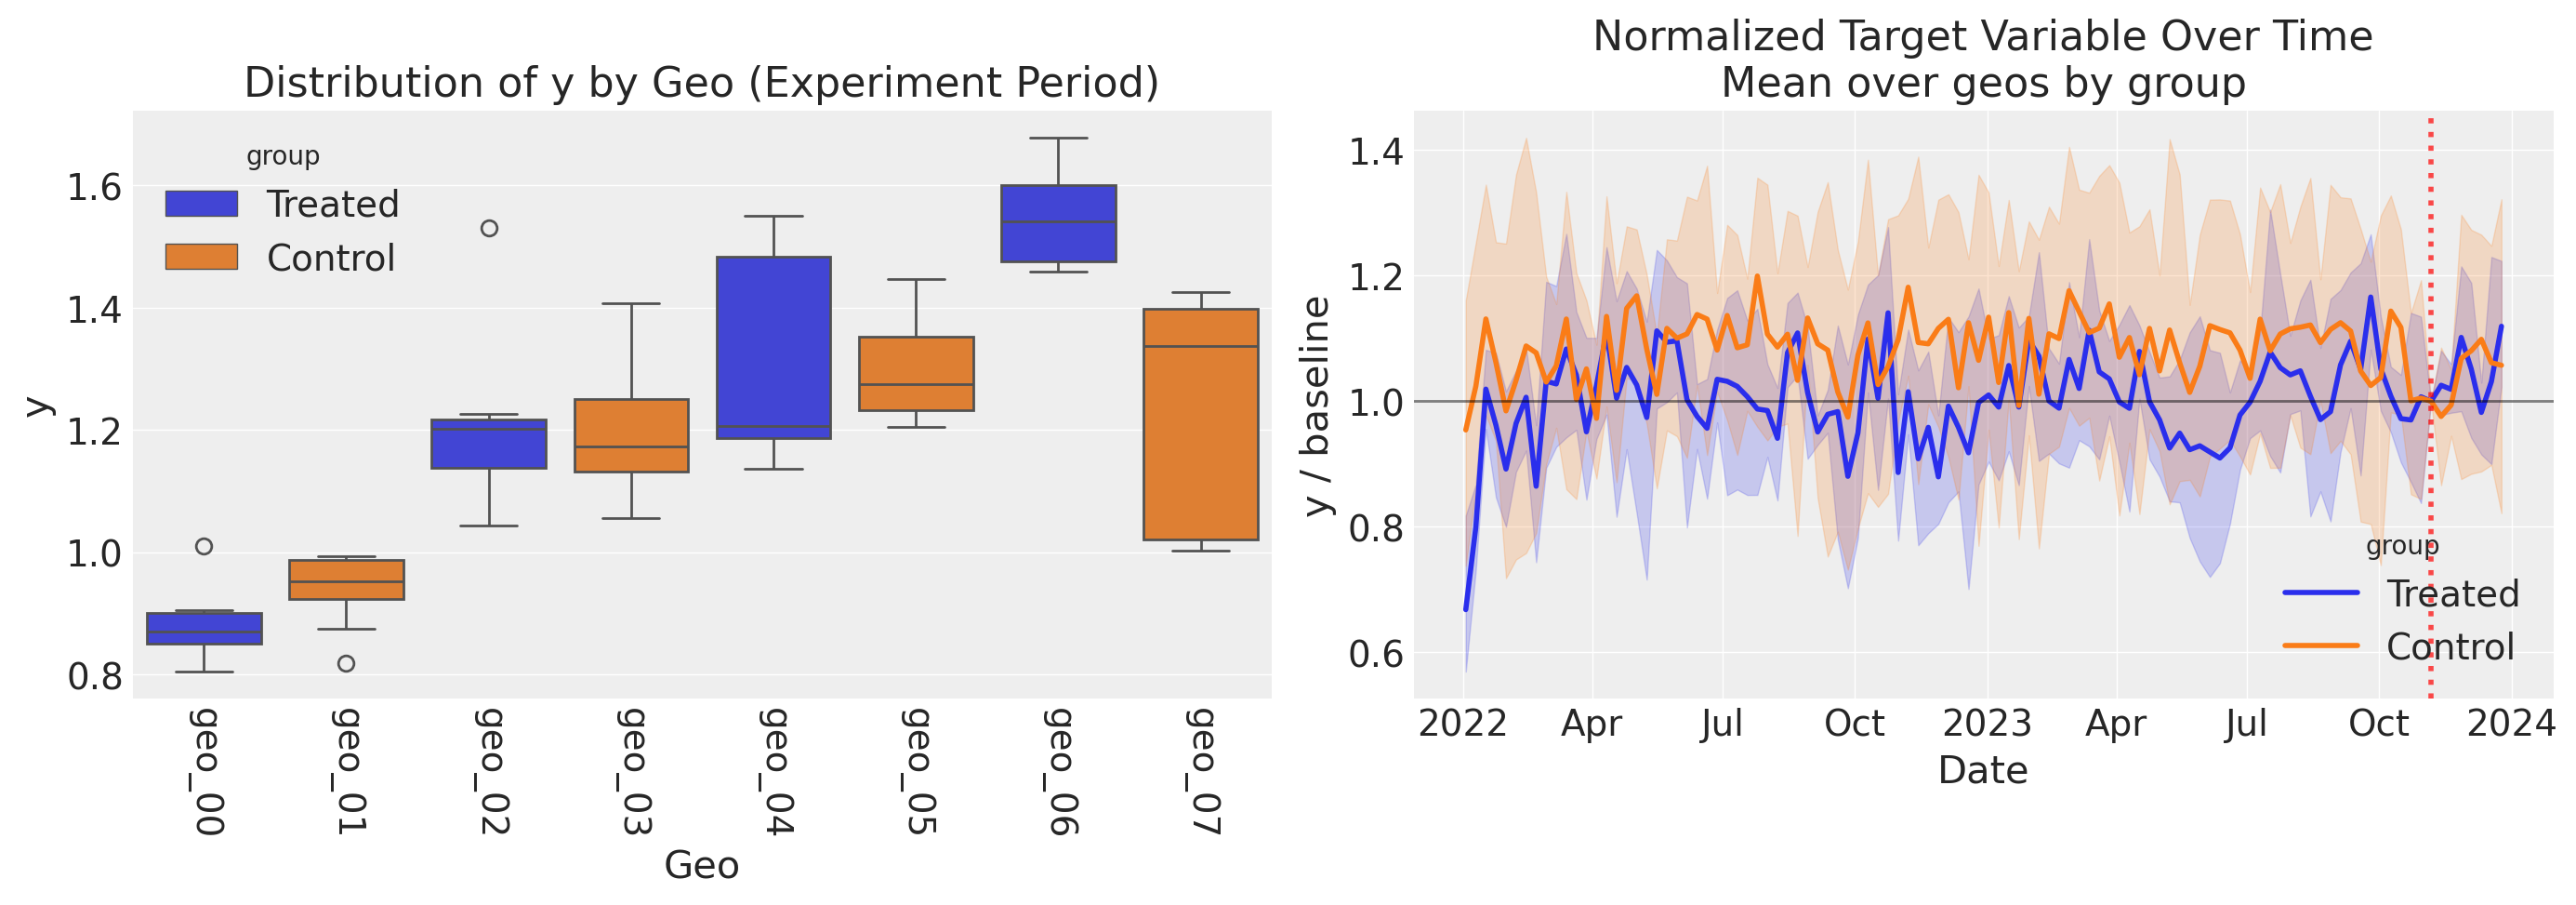

In [15]:
# Visualize generated data - showing experiment effect on outcomes
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Distribution of y by geo (during experiment)
ax = axes[0]
exp_data = df[df["date"] >= experiment_start_date]
sns.boxplot(data=exp_data, x="geo", y="y", hue="group", dodge=False, ax=ax)
ax.set_title("Distribution of y by Geo (Experiment Period)")
ax.set_xlabel("Geo")
ax.set_ylabel("y")
ax.tick_params(axis="x", rotation=-90)

# Normalize y by each geo's value at the intervention onset
# This removes geo-level baseline differences, making the experiment effect visible
onset_values = df[df["date"] == experiment_start_date].set_index("geo")["y"]
df["y_normalized"] = df.apply(lambda row: row["y"] / onset_values[row["geo"]], axis=1)

# Plot 2: Normalized y over time comparing treated vs control
ax = axes[1]
sns.lineplot(
    data=df, x="date", y="y_normalized", hue="group", ax=ax, errorbar=("ci", 95)
)
ax.axvline(experiment_start_date, color="red", linestyle=":", linewidth=2, alpha=0.7)
ax.axhline(1.0, color="black", linestyle="-", linewidth=1, alpha=0.5)
ax.set_title("Normalized Target Variable Over Time\nMean over geos by group")
ax.set_xlabel("Date")
ax.set_ylabel("y / baseline")
format_date_axis(ax)

plt.tight_layout()
plt.show()

**Left panel:** Distribution of `y` by geo during the experiment period. Each box shows the spread of weekly outcomes for one geo, colored by group (treated vs. control). Notice the substantial geo-level heterogeneity in outcomes--some geos have much higher baseline sales than others, reflecting differences in market size and media response. This variability means that plotting the raw outcome over time would drown out any experiment effect.

**Right panel:** To reveal the experiment's impact, we normalize each geo's `y` by its value at the intervention onset, removing geo-level baseline differences (akin to a fixed effect). All geos are indexed to 1.0 at the experiment start (black horizontal line). The treated group shows an uptick during the experiment period (red dashed line) relative to the control group, which stays near 1.0. The 95% CI bands represent variability across geos within each group.

## Fit MMM Without Calibration

First, let's fit a standard MMM without lift test calibration to establish a baseline.

In [16]:
# Prepare data
X = df[["date", "geo", "channel_1", "channel_2"]].copy()
y = df["y"]

# Initialize MMM (same structure as data generation)
mmm_uncalibrated = MMM(
    date_column="date",
    channel_columns=channels,
    adstock=GeometricAdstock(priors=adstock_priors, l_max=8),
    saturation=LogisticSaturation(priors=saturation_priors),
    dims=("geo",),
)

mmm_uncalibrated.build_model(X, y)
print("Uncalibrated model built")

Uncalibrated model built


In [17]:
mmm_uncalibrated.model_config

{'intercept': Prior("Normal", mu=0, sigma=2, dims="geo"),
 'likelihood': Prior("Normal", sigma=Prior("HalfNormal", sigma=2, dims="geo"), dims=("date", "geo")),
 'gamma_control': Prior("Normal", mu=0, sigma=2, dims=("geo", "control")),
 'gamma_fourier': Prior("Laplace", mu=0, b=1, dims=("geo", "fourier_mode")),
 'adstock_alpha': Prior("Beta", mu=Prior("Beta", alpha=2, beta=2, dims="channel"), nu=Prior("HalfNormal", sigma=10, dims="channel"), dims=("geo", "channel")),
 'saturation_lam': Prior("Gamma", mu=Prior("Gamma", alpha=4, beta=1.0, dims="channel"), sigma=Prior("HalfNormal", sigma=2, dims="channel"), dims=("geo", "channel")),
 'saturation_beta': Prior("TruncatedNormal", mu=Prior("HalfNormal", sigma=1, dims="channel"), sigma=Prior("HalfNormal", sigma=0.3, dims="channel"), lower=0.01, upper=2.0, dims=("geo", "channel"))}

The model configuration above reveals the **pooling structure** across geos for each parameter type. The key distinction is between the `dims` of the outer prior (which determines the parameter shape) and the `dims` of the hyperpriors (which determine how information is shared):

- **Saturation (`lam`, `beta`)** — *Hierarchical / partial pooling* over geos: The outer prior has `dims=("geo", "channel")`, so each geo gets its own parameter. But the hyperpriors (`mu`, `sigma`) have `dims="channel"` only, meaning all geos within a channel share the same population-level mean and spread. This is the structure that enables information to flow from tested to untested geos through the shared population parameters.

- **Adstock (`alpha`)** — *Hierarchical / partial pooling* over geos: The outer prior has `dims=("geo", "channel")`, with `mu` and `nu` (concentration) hyperpriors at `dims="channel"`. Each geo gets its own adstock decay rate, drawn from a channel-level population Beta distribution.

The table below summarizes how `dims` determines pooling behavior in the multidimensional MMM:

| Strategy | Prior dims | Hyperpriors | Information sharing |
|----------|------------|-------------|---------------------|
| **Complete pooling** | `channel` only | Constants | No geo variation; one value per channel |
| **Partial pooling** | `(geo, channel)` | Priors with `dims="channel"` | Shared population across geos; geo-specific draws |
| **No pooling** | `(geo, channel)` | Constants | Independent draws per geo-channel |

For this notebook, the hierarchical (partial pooling) structure on the saturation parameters is crucial: it means that calibrating a subset of geos with lift tests updates the population-level parameters, which in turn provides better priors for all untested geos.

In [18]:
# Fit the model using nutpie for faster sampling
fit_kwargs = {
    "tune": 1000,
    "draws": 1000,
    "chains": 4,
    "random_seed": rng,
    "nuts_sampler": "nutpie",
}

idata_uncalibrated = mmm_uncalibrated.fit(X, y, **fit_kwargs)
print("\nUncalibrated model fitted")

Error updating progress display: <ContextVar name='parent_header' at 0x1083730b0>


Output()


Uncalibrated model fitted


/var/folders/pd/p2qnky2x3xl4w3mgc4lct2200000gn/T/ipykernel_58742/1936144594.py:95: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


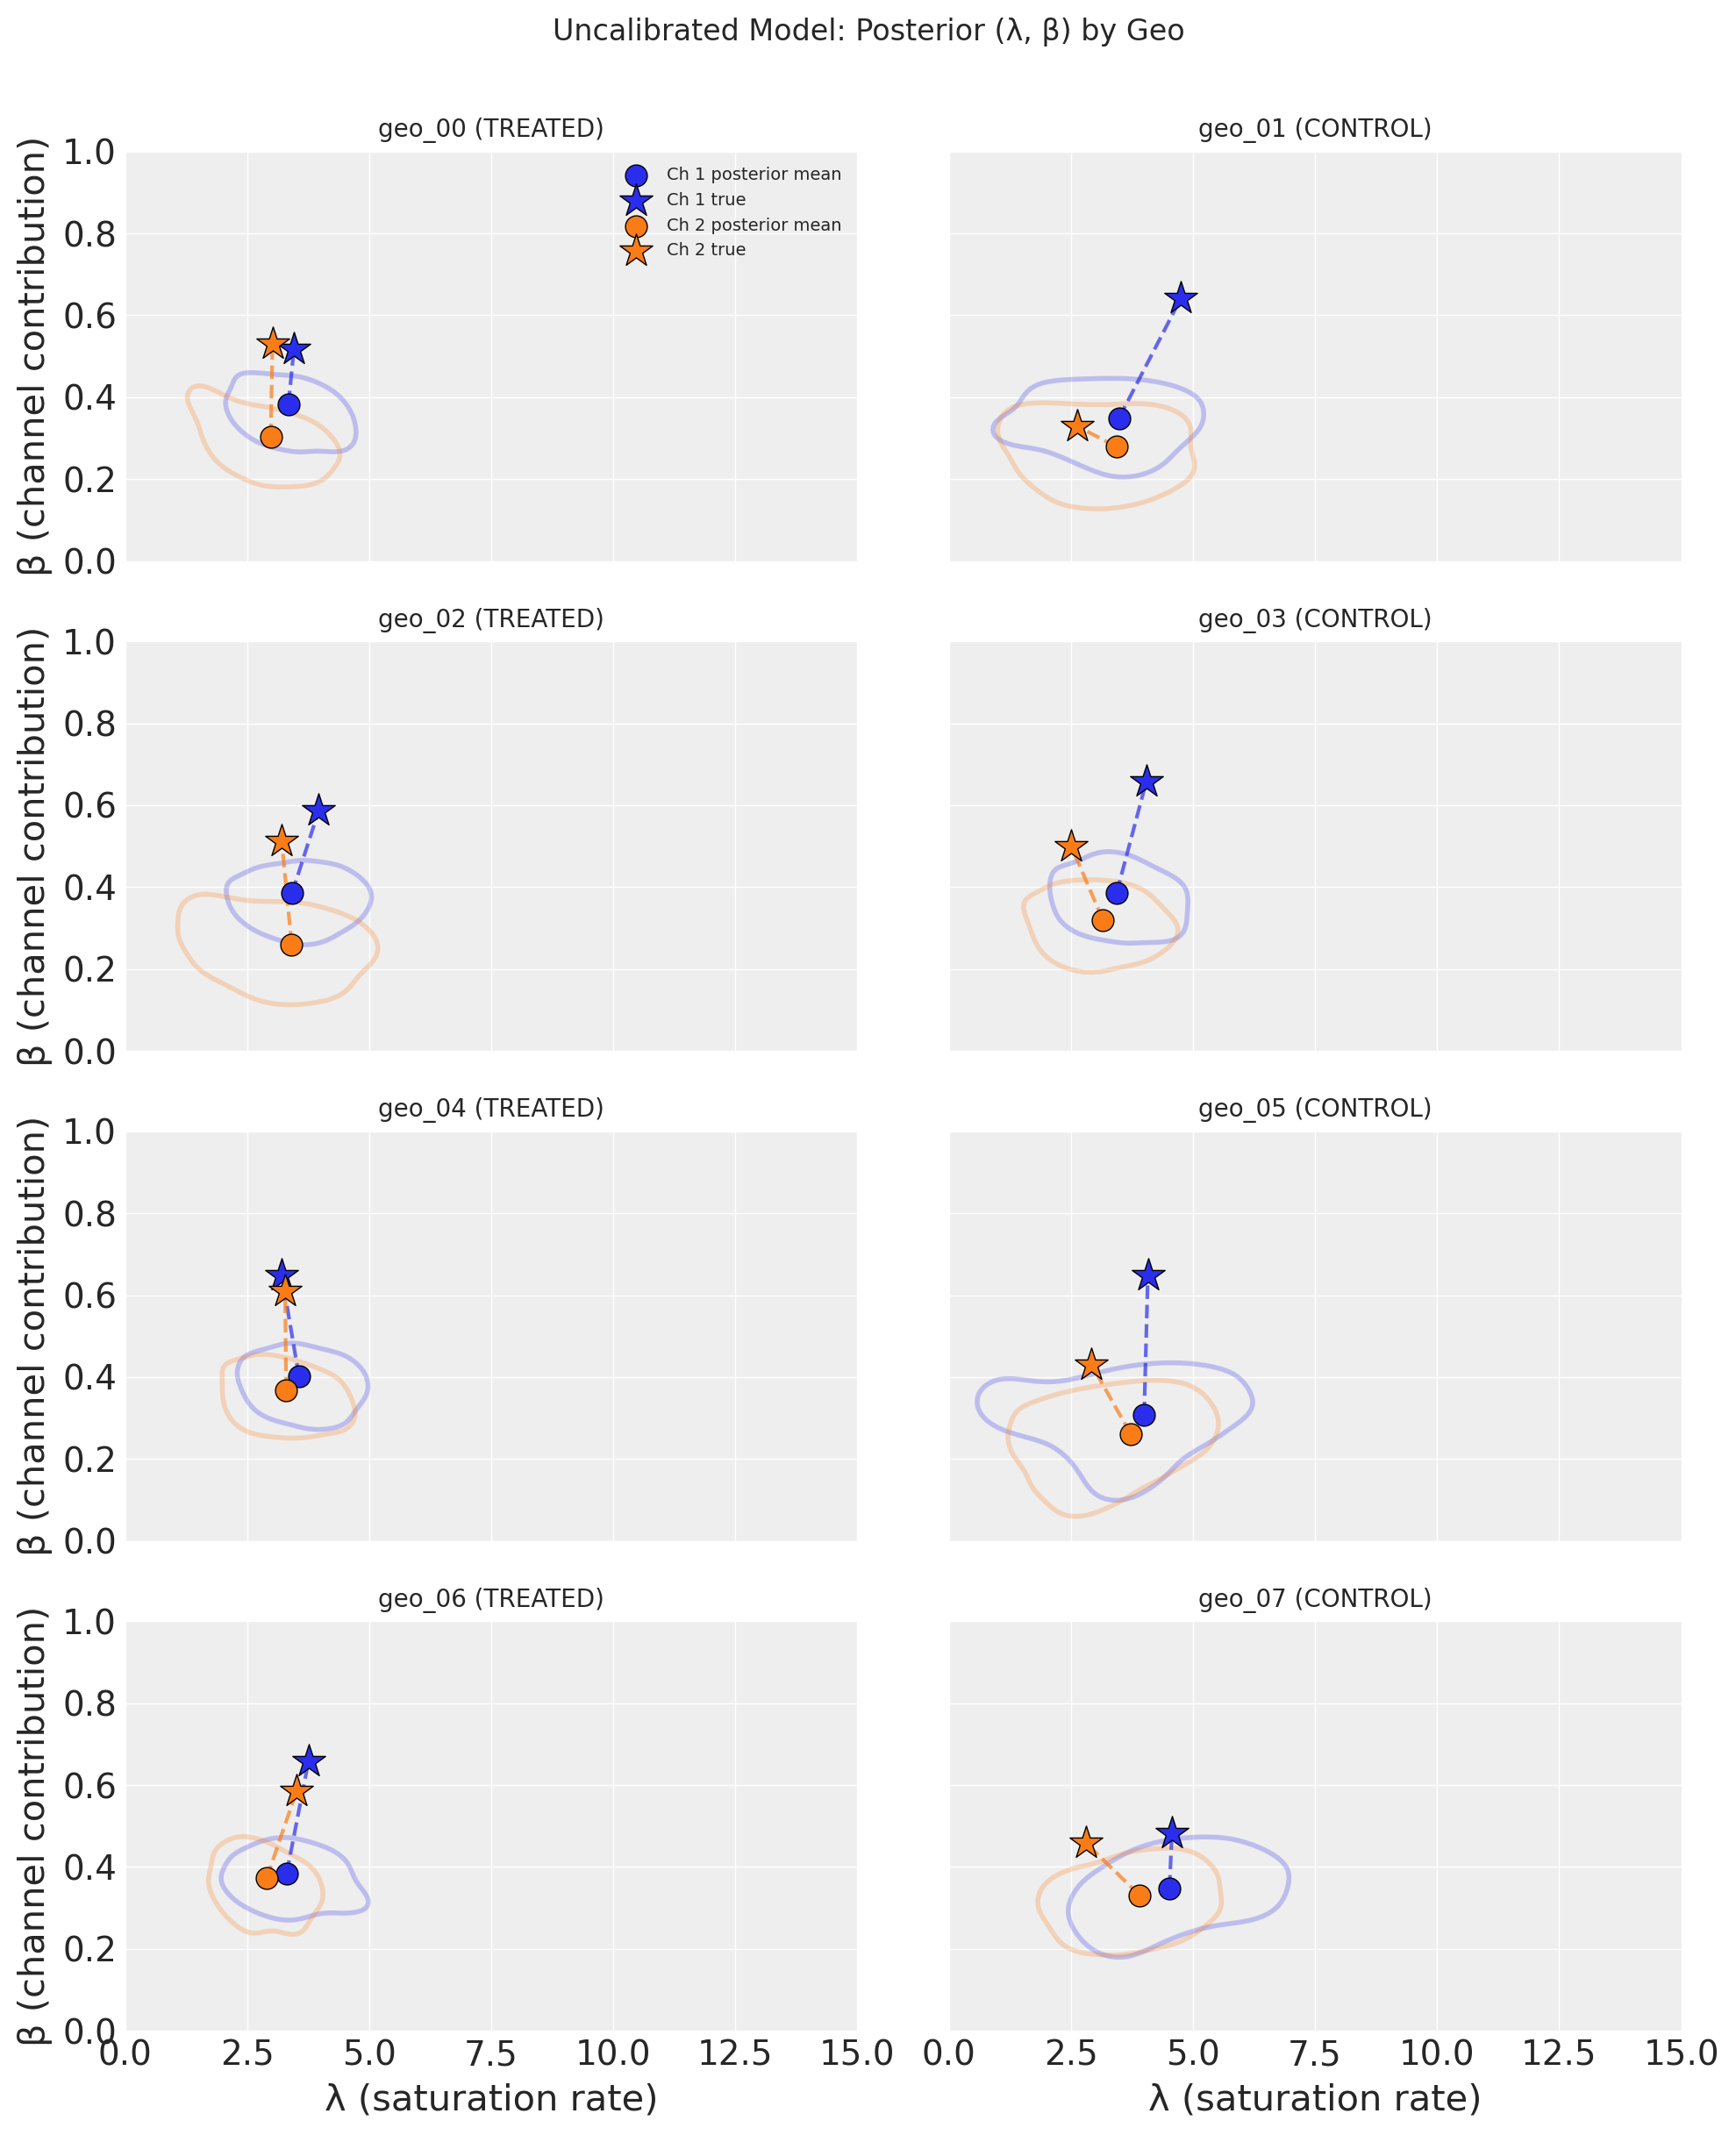

In [19]:
# Visualize parameter estimates in 2D parameter space (lam vs beta)
# Left column: treated geos, Right column: control geos
# Channels distinguished by color, KDE contours show posterior density
posterior = idata_uncalibrated.posterior

fig, axes = plt.subplots(4, 2, figsize=(10, 12), sharex=True, sharey=True)

for row, (treated_geo, control_geo) in enumerate(
    zip(treated_geos, control_geos, strict=True)
):
    for col, (geo, label) in enumerate(
        [(treated_geo, "TREATED"), (control_geo, "CONTROL")]
    ):
        ax = axes[row, col]
        geo_idx = geos.index(geo)

        for ch_idx, _ch_name in enumerate(channels):
            color = f"C{ch_idx}"
            ch_label = f"Ch {ch_idx + 1}"

            # Posterior samples
            lam_samples = posterior["saturation_lam"][
                :, :, geo_idx, ch_idx
            ].values.flatten()
            beta_samples = posterior["saturation_beta"][
                :, :, geo_idx, ch_idx
            ].values.flatten()

            # Compute posterior mean and true values
            mean_lam = np.mean(lam_samples)
            mean_beta = np.mean(beta_samples)
            true_lam_val = true_lam[geo_idx, ch_idx]
            true_beta_val = true_beta[geo_idx, ch_idx]

            # KDE contour at 50% density level
            sns.kdeplot(
                x=lam_samples,
                y=beta_samples,
                levels=[0.5],
                color=color,
                ax=ax,
                fill=False,
                alpha=0.25,
            )

            # Line from posterior mean to true value (error vector)
            ax.plot(
                [mean_lam, true_lam_val],
                [mean_beta, true_beta_val],
                color=color,
                linewidth=1.5,
                linestyle="--",
                alpha=0.7,
                zorder=4,
            )

            # Plot posterior mean
            ax.scatter(
                mean_lam,
                mean_beta,
                marker="o",
                s=80,
                color=color,
                edgecolors="black",
                linewidths=0.5,
                zorder=5,
                label=f"{ch_label} posterior mean",
            )

            # Plot true value
            ax.scatter(
                true_lam_val,
                true_beta_val,
                marker="*",
                s=200,
                color=color,
                edgecolors="black",
                linewidths=0.5,
                zorder=6,
                label=f"{ch_label} true",
            )

        ax.set_title(f"{geo} ({label})", fontsize=10)
        if row == 3:
            ax.set_xlabel("λ (saturation rate)")
        if col == 0:
            ax.set_ylabel("β (channel contribution)")
        if row == 0 and col == 0:
            ax.legend(fontsize=7, loc="upper right")

axes[0, 0].set_xlim(0, 15)
axes[0, 0].set_ylim(0, 1)

plt.suptitle("Uncalibrated Model: Posterior (λ, β) by Geo", fontsize=12, y=1.01)
plt.tight_layout()
plt.show()

Each subplot shows one geo's posterior distribution in the (λ, β) parameter space, with **treated geos on the left** and **control geos on the right**. Channels are distinguished by color. The shaded KDE contours enclose the 50% highest-density region, circles mark the posterior mean, and stars mark the true parameter values.

**Key takeaway:** The uncalibrated model struggles to recover the true parameters. The posterior distributions are broad and often do not overlap with the true values (stars). This is a direct consequence of the high correlation between channels--without causal information, the model cannot confidently separate Channel 1's contribution from Channel 2's. The posterior means are biased, and the uncertainty is large. This motivates the lift test calibration we add next.

## Create Lift Test Measurements

Recall that during data generation, we simulated a geo-level lift test on **channel 1** in 4 treated geos. The experiment is visible in the data: treated geos have increased channel 1 spend during the final 8 weeks.

Now we extract the lift test measurements that would come from analyzing this experiment (e.g., via CausalPy synthetic control). For each treated geo, we calculate:
- `x`: baseline (normalized) spend *before* the experiment
- `delta_x`: the incremental spend change applied during the experiment
- `delta_y`: the causal lift, computed from the true saturation curve (simulating what CausalPy would estimate)

**Key principle**: The lift test uses the **same saturation function** that the model uses, ensuring consistency.

:::{admonition} Adstock and Lift Test Interpretation
:class: warning

This notebook uses a model with adstock (`l_max=8`), meaning media effects carry over across multiple weeks. However, the lift test `delta_y` values computed here represent the *instantaneous* saturation effect at a point in time, not the cumulative effect including carryover.

In practice, when adstock effects are significant, you should consider:

1. **Cumulative lift measurement**: Ensure your CausalPy analysis measures the *total* incremental outcome over the experiment period plus a post-experiment "cooldown" window that captures the carryover tail.

2. **Adjust the calibration target**: The `delta_y` you provide to the MMM should represent the cumulative contribution from the incremental spend, including any carryover effects that extend beyond the experiment end date.

3. **Simplify for demonstration**: If adstock effects are minimal (low `alpha` or short `l_max`), the instantaneous approximation used here is reasonable.

For this demonstration, we use the simpler instantaneous approach to keep the focus on the geo-level hierarchical calibration mechanism.
:::

In [20]:
# Define the saturation function matching the model
def saturation_function(x, lam, beta):
    """Compute saturation contribution (same as model uses)."""
    return (beta * logistic_saturation(x, lam)).eval()


# Create geo-specific curve functions for channel 1 (the test channel)
def get_geo_curve_fn(geo_idx, channel_idx=0):
    """Get saturation curve function for a specific geo and channel."""
    return partial(
        saturation_function,
        lam=true_lam[geo_idx, channel_idx],
        beta=true_beta[geo_idx, channel_idx],
    )

In [21]:
# Lift test setup (already defined during data generation)
# Recap the experiment parameters:
print("Lift Test Setup (from data generation):")
print(f"  Test channel: {test_channel}")
print(
    f"  Experiment period: {experiment_start_date.date()} to {experiment_end_date.date()}"
)
print(f"  Treated geos: {treated_geos}")
print(f"  Control geos: {control_geos}")
print(f"  Spend increase (delta_x): {delta_x_experiment}")

Lift Test Setup (from data generation):
  Test channel: channel_1
  Experiment period: 2023-11-06 to 2023-12-25
  Treated geos: ['geo_00', 'geo_02', 'geo_04', 'geo_06']
  Control geos: ['geo_01', 'geo_03', 'geo_05', 'geo_07']
  Spend increase (delta_x): 0.15


In [22]:
def create_lift_test(
    geo: str, geo_idx: int, x: float, delta_x: float, sigma: float
) -> dict:
    """
    Create a lift test measurement using the geo-specific saturation curve.

    This directly uses the saturation function with geo-specific parameters,
    ensuring consistency with what add_lift_test_measurements() expects.

    In practice, delta_y would come from a synthetic control analysis
    (e.g., CausalPy). Here we compute it from the known true curve for that geo.
    """
    # Use geo-specific parameters
    geo_curve_fn = get_geo_curve_fn(geo_idx, channel_idx=0)
    delta_y = geo_curve_fn(x + delta_x) - geo_curve_fn(x)

    return {
        "channel": test_channel,
        "geo": geo,
        "x": x,
        "delta_x": delta_x,
        "delta_y": float(delta_y),
        "sigma": sigma,
    }


# Create lift tests based on the actual experiment in the data
# For each treated geo:
#   - x = baseline spend (pre-experiment average for that geo)
#   - delta_x = the actual spend increase applied during the experiment
#   - delta_y = computed from geo-specific true saturation curve (simulating CausalPy)

# Scale lift test uncertainty with geo size (larger geos = more precise estimates).
# In practice, sigma would come from the synthetic control analysis (e.g., CausalPy).
avg_sales_by_geo = df.groupby("geo")["y"].mean()
median_sales = avg_sales_by_geo.median()
base_sigma = 0.015  # Base uncertainty for median-sized geo

lift_test_results = []

for geo in treated_geos:
    geo_idx = geos.index(geo)
    geo_data = df[df["geo"] == geo]

    # Baseline spend: average channel_1 spend BEFORE the experiment
    pre_experiment_data = geo_data[geo_data["date"] < experiment_start_date]
    x_baseline = pre_experiment_data[test_channel].mean()

    # The spend increase is what we applied during data generation
    delta_x = delta_x_experiment

    # Measurement uncertainty scales inversely with sqrt of geo size.
    # Larger geos (more sales) yield more precise lift estimates.
    sigma = base_sigma * np.sqrt(median_sales / avg_sales_by_geo[geo])

    lift_test = create_lift_test(geo, geo_idx, x_baseline, delta_x, sigma)
    lift_test_results.append(lift_test)

    # Verify: actual spend during experiment should be close to x + delta_x
    during_experiment_data = geo_data[geo_data["date"] >= experiment_start_date]
    actual_spend = during_experiment_data[test_channel].mean()

    # Show geo-specific parameters
    geo_lam = true_lam[geo_idx, 0]
    geo_beta = true_beta[geo_idx, 0]

    print(
        f"{geo}: x={x_baseline:.3f}, delta_x={delta_x:.2f}, delta_y={lift_test['delta_y']:.4f} "
        f"(lam={geo_lam:.2f}, beta={geo_beta:.2f})"
    )

df_lift_test = pd.DataFrame(lift_test_results)
print("\nLift Test DataFrame (geo-specific measurements):")
print("Note: Each delta_y is computed from that geo's true saturation curve.")
df_lift_test

geo_00: x=0.403, delta_x=0.15, delta_y=0.0725 (lam=3.46, beta=0.52)
geo_02: x=0.463, delta_x=0.15, delta_y=0.0665 (lam=3.96, beta=0.59)
geo_04: x=0.497, delta_x=0.15, delta_y=0.0744 (lam=3.21, beta=0.65)
geo_06: x=0.589, delta_x=0.15, delta_y=0.0527 (lam=3.76, beta=0.66)

Lift Test DataFrame (geo-specific measurements):
Note: Each delta_y is computed from that geo's true saturation curve.


channel     geo         x  delta_x   delta_y     sigma
0  channel_1  geo_00  0.403014     0.15  0.072540  0.018022
1  channel_1  geo_02  0.463227     0.15  0.066473  0.015906
2  channel_1  geo_04  0.497020     0.15  0.074366  0.014748
3  channel_1  geo_06  0.588885     0.15  0.052717  0.013568

/var/folders/pd/p2qnky2x3xl4w3mgc4lct2200000gn/T/ipykernel_58742/2664596525.py:71: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


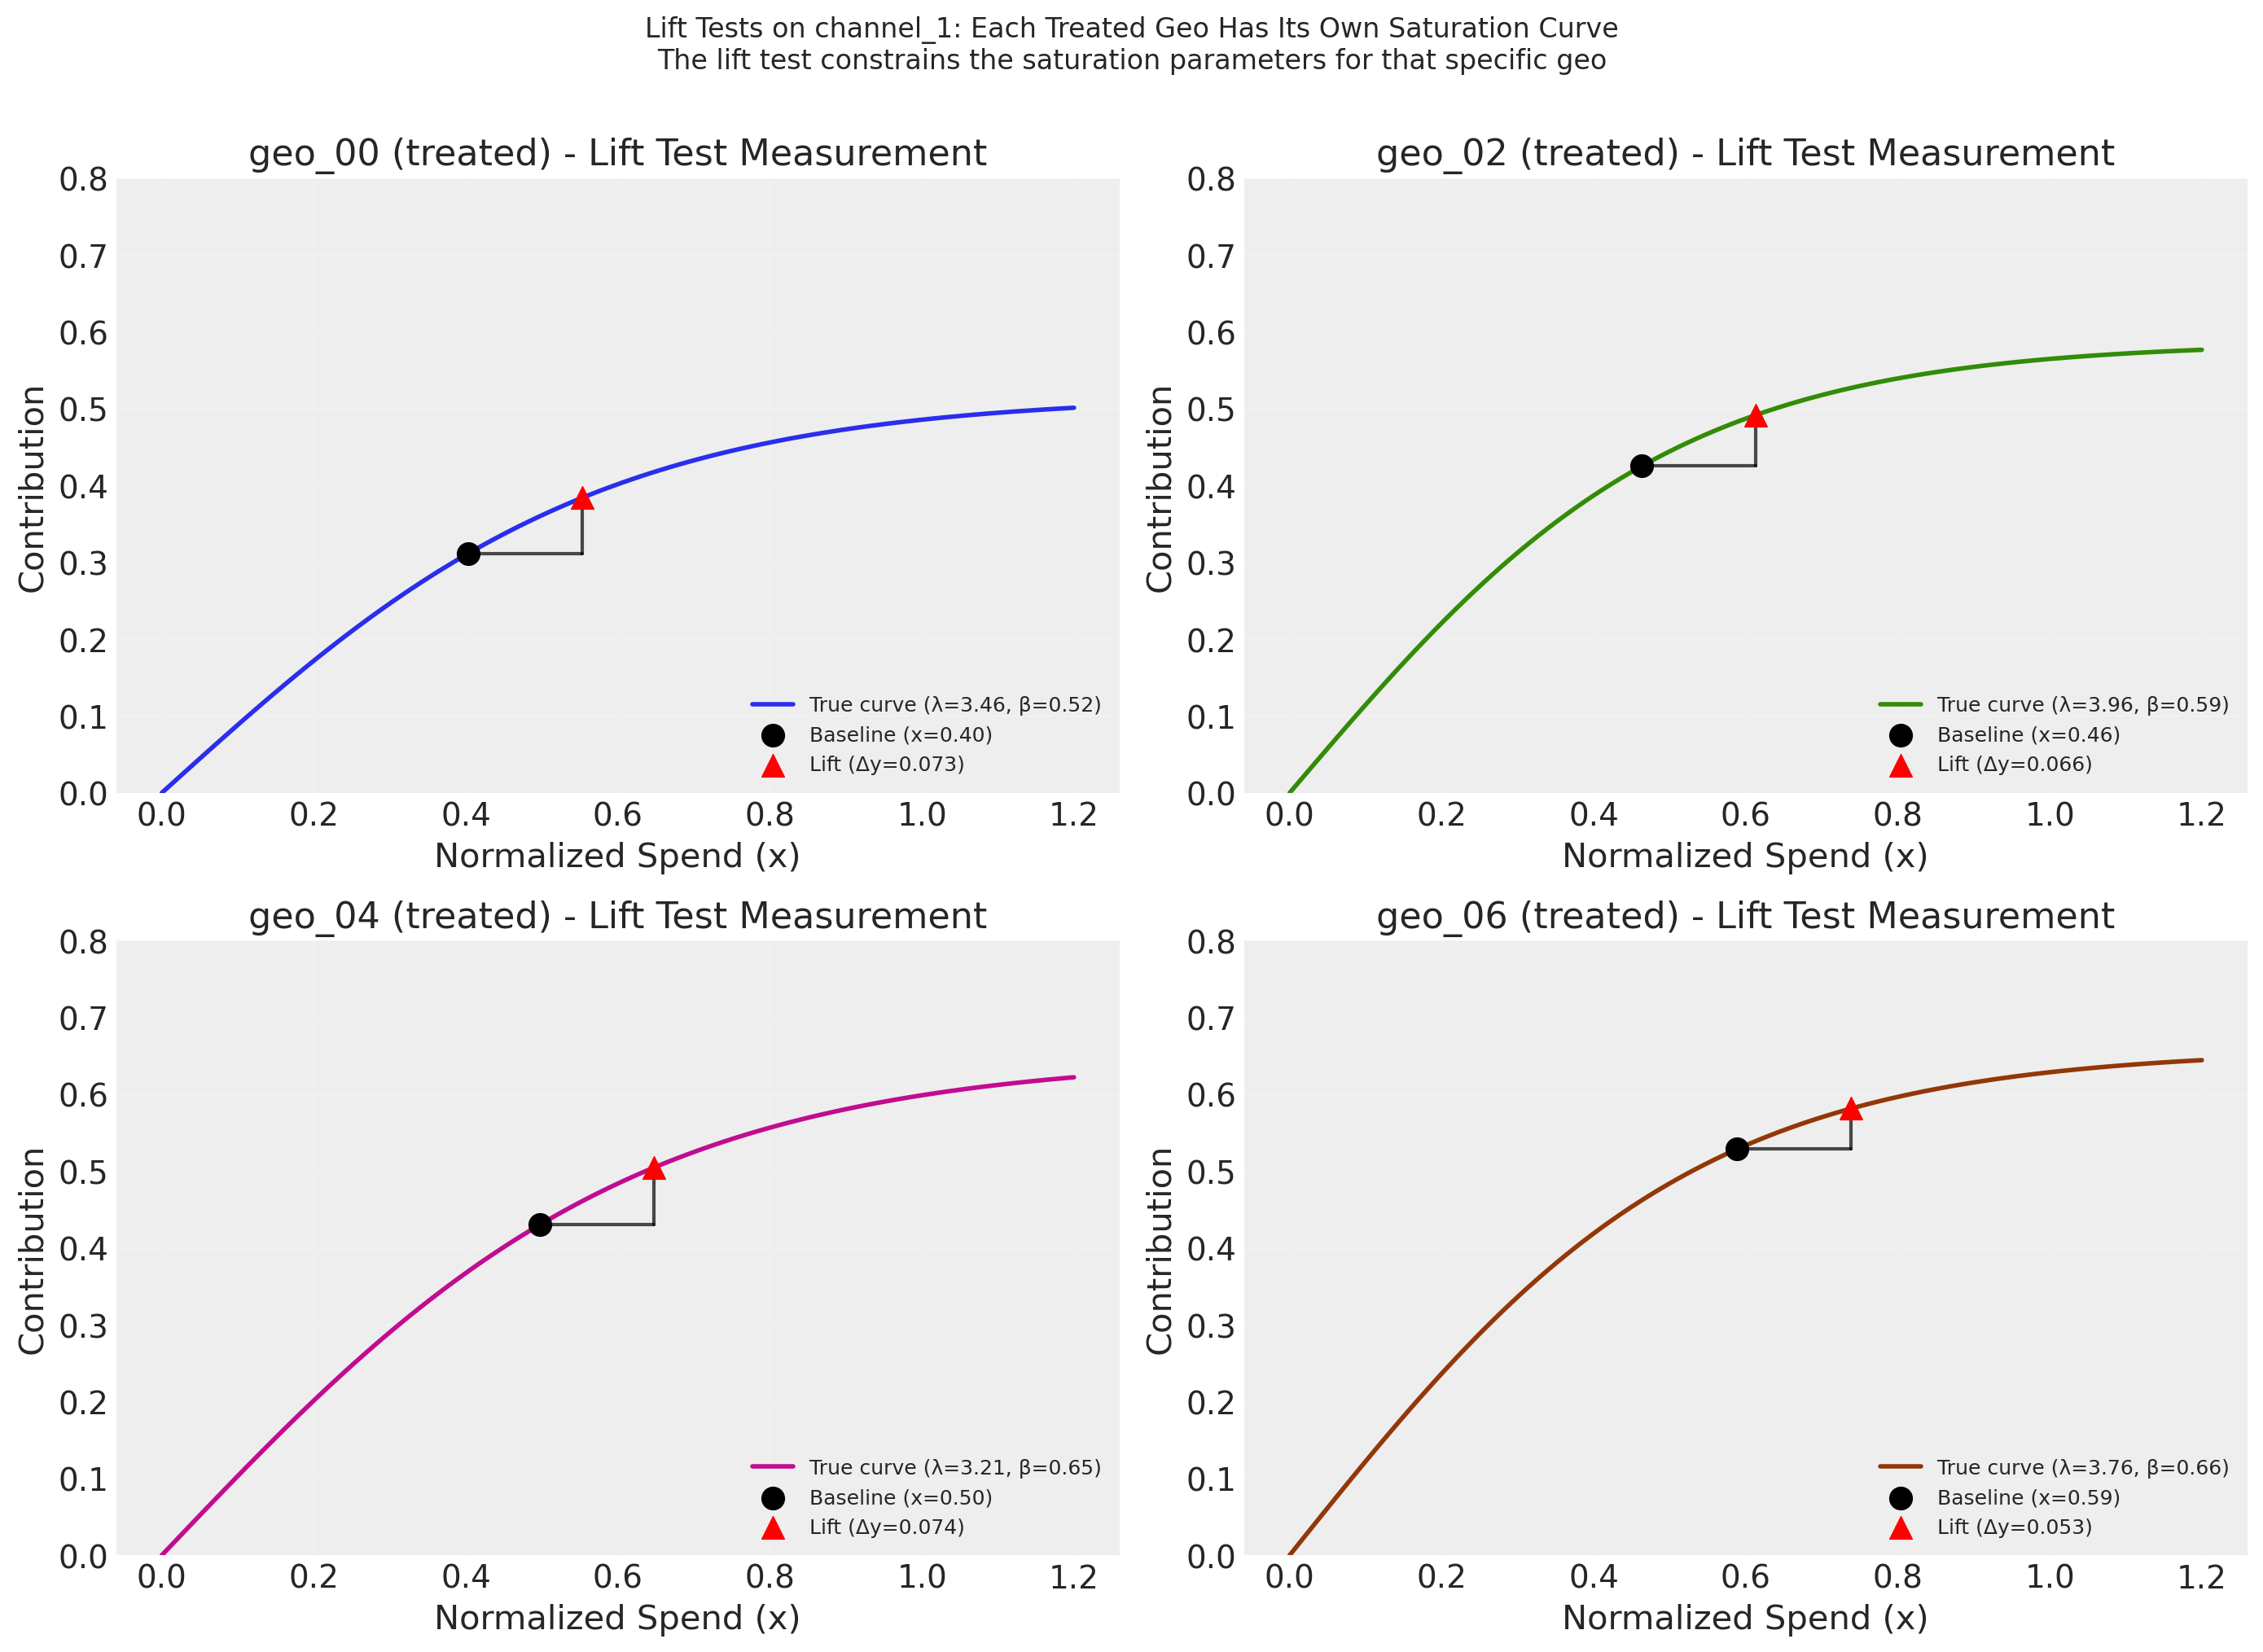


Key insight: Each geo's lift test measures a point on THAT GEO's saturation curve.
Through hierarchical priors, these measurements also inform the population distribution,
which in turn provides better priors for the control geos that weren't tested.


In [23]:
# Visualize lift tests on geo-specific saturation curves
# Each treated geo has its own curve, so we show one subplot per geo
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
xx = np.linspace(0, 1.2, 100)
axes = axes.flatten()

colors = ["C0", "C2", "C3", "C4"]  # Different color per geo

for i, (_idx, row) in enumerate(df_lift_test.iterrows()):
    ax = axes[i]
    geo = row["geo"]
    geo_idx = geos.index(geo)

    # Get geo-specific curve
    geo_curve_fn = get_geo_curve_fn(geo_idx, channel_idx=0)
    geo_curve = geo_curve_fn(xx)
    geo_lam = true_lam[geo_idx, 0]
    geo_beta = true_beta[geo_idx, 0]

    # Plot true saturation curve for this geo
    ax.plot(
        xx,
        geo_curve,
        "-",
        color=colors[i],
        linewidth=2,
        label=f"True curve (λ={geo_lam:.2f}, β={geo_beta:.2f})",
    )

    # Plot lift test triangle
    x = row["x"]
    delta_x = row["delta_x"]
    delta_y = row["delta_y"]
    y_base = geo_curve_fn(x)

    # Draw triangle showing lift
    ax.plot([x, x + delta_x], [y_base, y_base], "k-", linewidth=1.5, alpha=0.7)
    ax.plot(
        [x + delta_x, x + delta_x],
        [y_base, y_base + delta_y],
        "k-",
        linewidth=1.5,
        alpha=0.7,
    )
    ax.scatter(
        [x], [y_base], color="black", s=100, zorder=5, label=f"Baseline (x={x:.2f})"
    )
    ax.scatter(
        [x + delta_x],
        [y_base + delta_y],
        color="red",
        s=100,
        zorder=5,
        marker="^",
        label=f"Lift (Δy={delta_y:.3f})",
    )

    ax.set_xlabel("Normalized Spend (x)")
    ax.set_ylabel("Contribution")
    ax.set_title(f"{geo} (treated) - Lift Test Measurement")
    ax.legend(loc="lower right", fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0, 0.8)

plt.suptitle(
    f"Lift Tests on {test_channel}: Each Treated Geo Has Its Own Saturation Curve\n"
    "The lift test constrains the saturation parameters for that specific geo",
    fontsize=12,
    y=1.01,
)
plt.tight_layout()
plt.show()

print(
    "\nKey insight: Each geo's lift test measures a point on THAT GEO's saturation curve."
)
print(
    "Through hierarchical priors, these measurements also inform the population distribution,"
)
print("which in turn provides better priors for the control geos that weren't tested.")

## Fit MMM With Lift Test Calibration

Now we fit a new MMM and add the lift test measurements to calibrate it.

In [24]:
# Initialize calibrated MMM with same priors
mmm_calibrated = MMM(
    date_column="date",
    channel_columns=channels,
    adstock=GeometricAdstock(priors=adstock_priors, l_max=8),
    saturation=LogisticSaturation(priors=saturation_priors),
    dims=("geo",),
)

mmm_calibrated.build_model(X, y)
print("Calibrated model built")

Calibrated model built


In [25]:
# Add lift test measurements
mmm_calibrated.add_lift_test_measurements(df_lift_test)
print(f"Added {len(df_lift_test)} lift test measurements")
print(f"Lift tests cover geos: {df_lift_test['geo'].unique().tolist()}")

Added 4 lift test measurements
Lift tests cover geos: ['geo_00', 'geo_02', 'geo_04', 'geo_06']


In [26]:
# Fit the calibrated model
idata_calibrated = mmm_calibrated.fit(X, y, **fit_kwargs)
print("\nCalibrated model fitted")

Error updating progress display: <ContextVar name='parent_header' at 0x1083730b0>


Output()


Calibrated model fitted


## Compare Results: Calibrated vs Uncalibrated

Let's compare parameter recovery between the two models.

In [27]:
# Extract posteriors for comparison
posterior_uncal = idata_uncalibrated.posterior
posterior_cal = idata_calibrated.posterior

# Compare treated geo (directly calibrated) vs control geo (indirectly calibrated)
# This demonstrates the hierarchical information flow

treated_geo_idx = 0  # geo_00 (treated)
control_geo_idx = 1  # geo_01 (control)
treated_geo = geos[treated_geo_idx]
control_geo = geos[control_geo_idx]

/var/folders/pd/p2qnky2x3xl4w3mgc4lct2200000gn/T/ipykernel_58742/1772151011.py:107: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


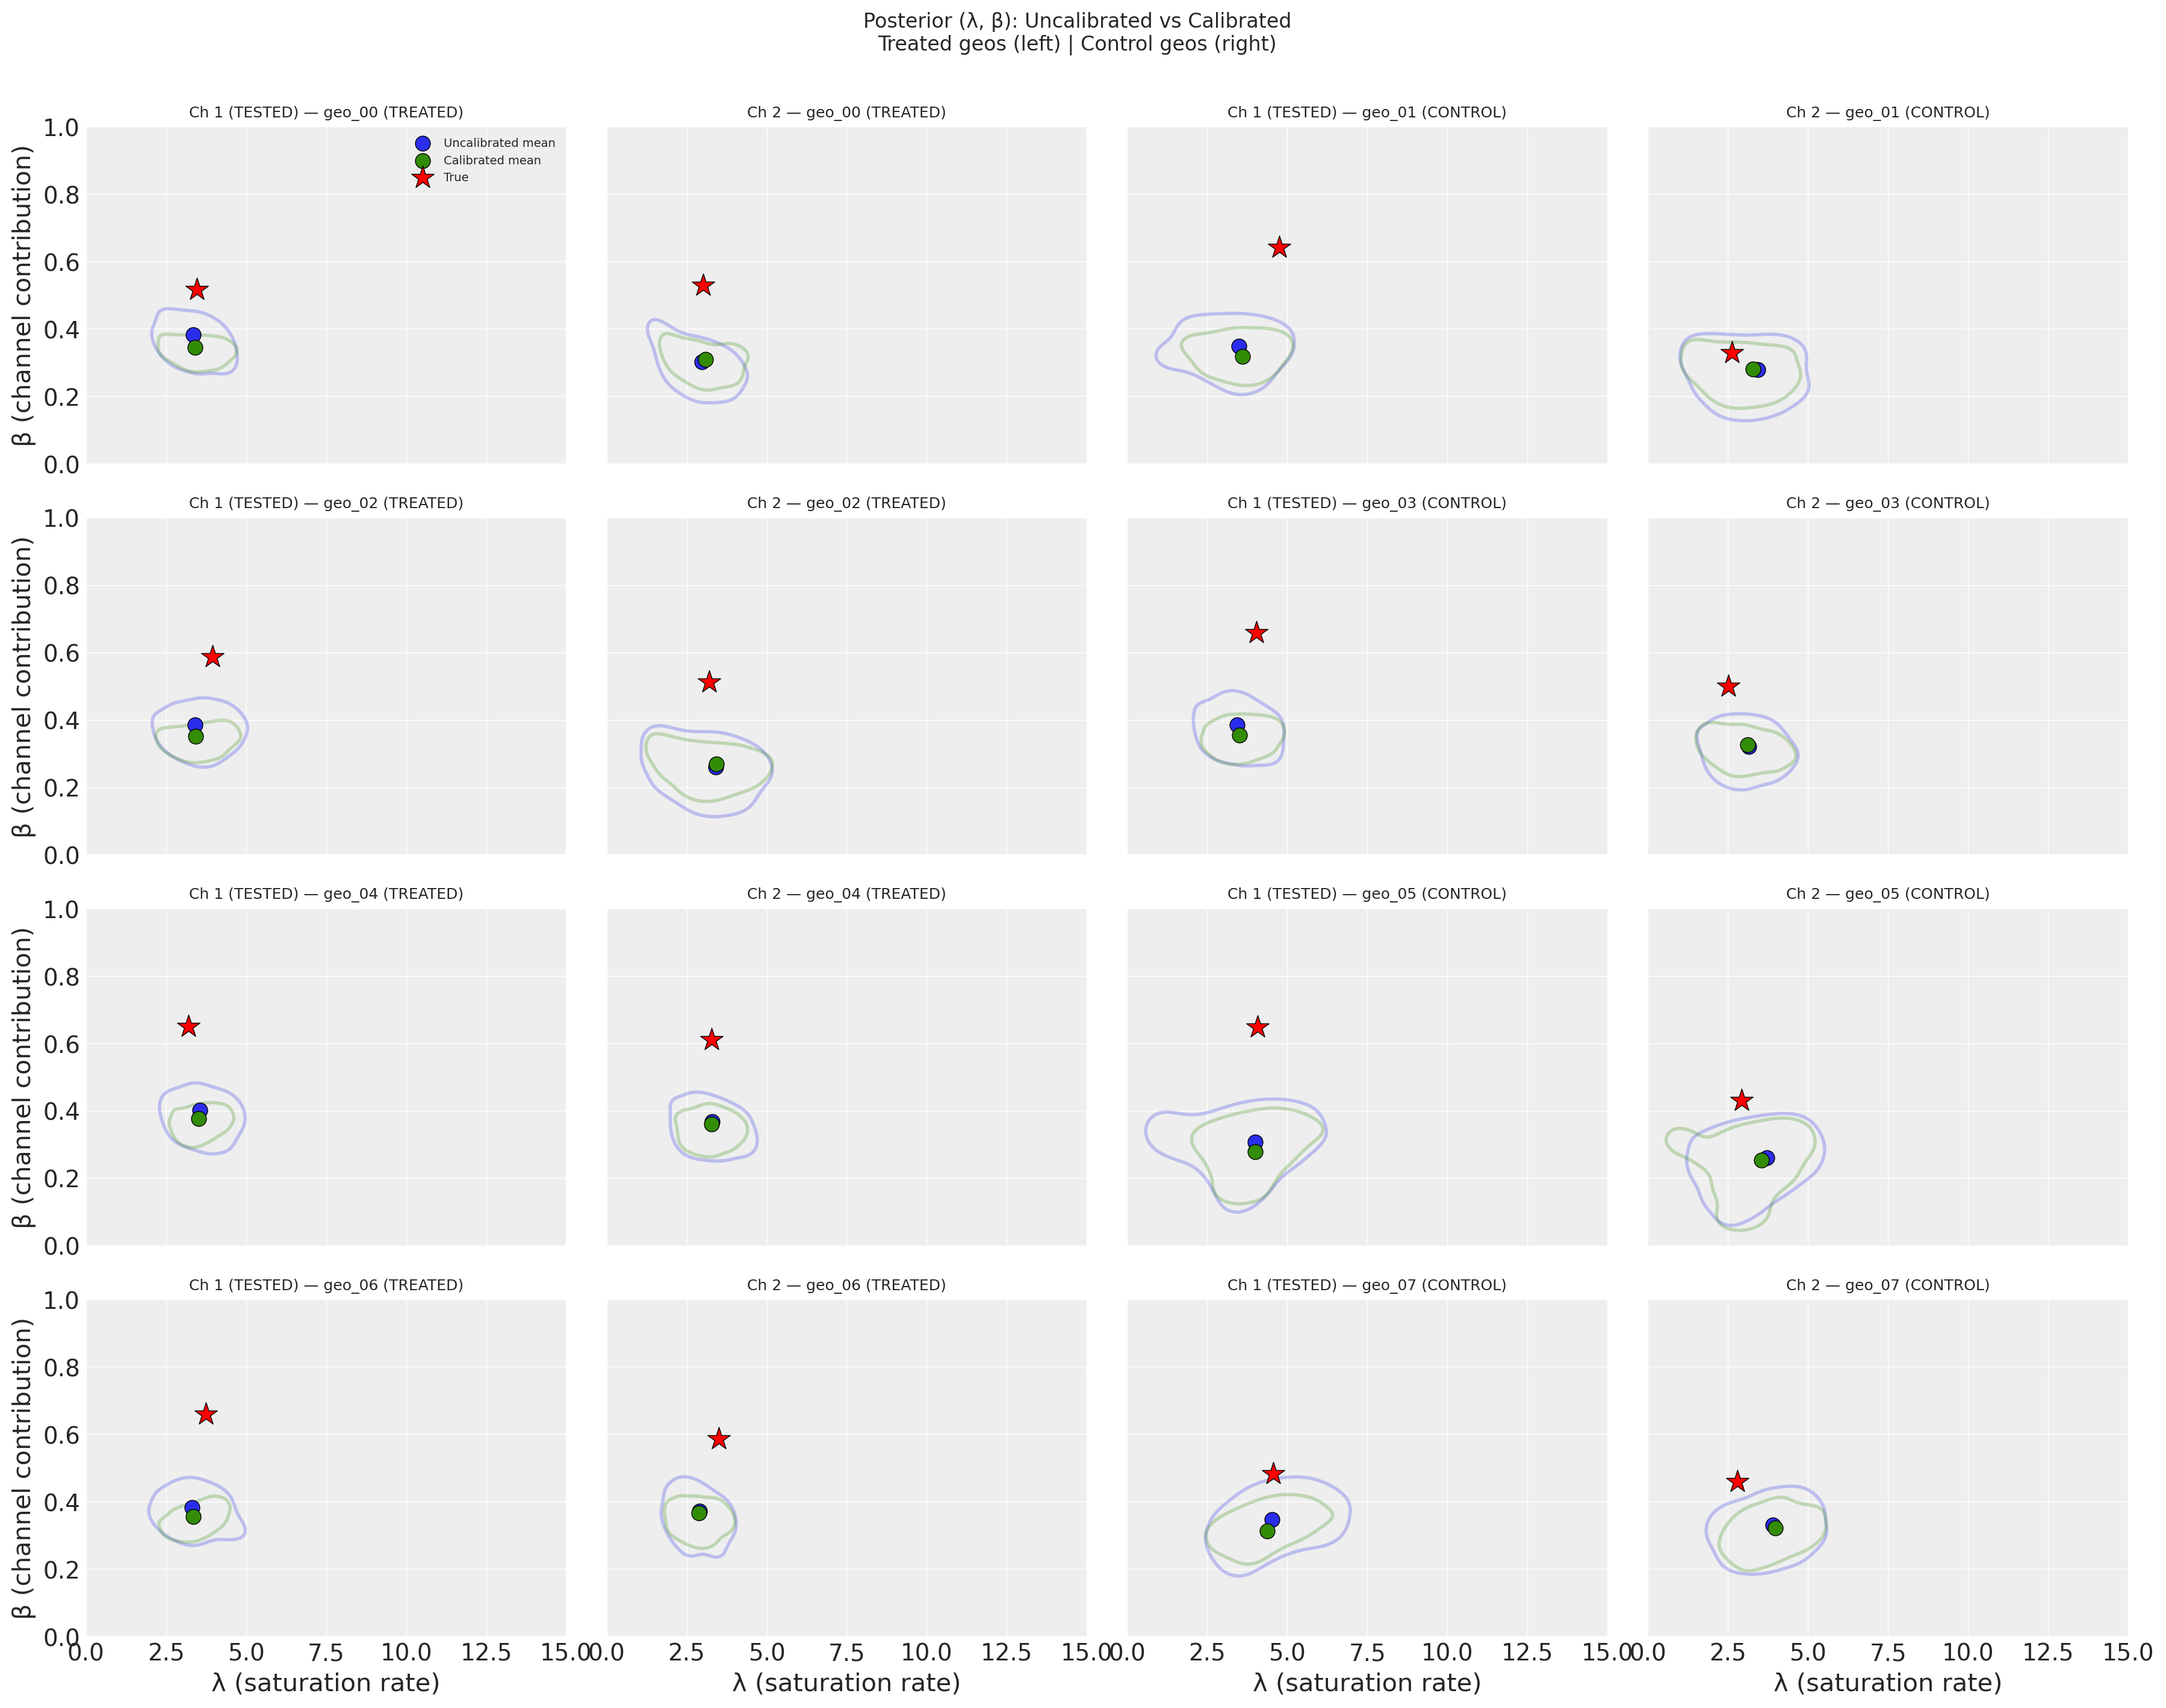

In [28]:
fig, axes = plt.subplots(4, 4, figsize=(18, 14), sharex=True, sharey=True)

for row, (treated_geo, control_geo) in enumerate(
    zip(treated_geos, control_geos, strict=True)
):
    for half, (geo, geo_label) in enumerate(
        [(treated_geo, "TREATED"), (control_geo, "CONTROL")]
    ):
        geo_idx = geos.index(geo)

        for ch_idx in range(len(channels)):
            col = half * 2 + ch_idx
            ax = axes[row, col]
            ch_label = f"Ch {ch_idx + 1}"
            tested_tag = " (TESTED)" if ch_idx == 0 else ""

            # Extract posterior samples
            lam_uncal = posterior_uncal["saturation_lam"][
                :, :, geo_idx, ch_idx
            ].values.flatten()
            beta_uncal = posterior_uncal["saturation_beta"][
                :, :, geo_idx, ch_idx
            ].values.flatten()
            lam_cal = posterior_cal["saturation_lam"][
                :, :, geo_idx, ch_idx
            ].values.flatten()
            beta_cal = posterior_cal["saturation_beta"][
                :, :, geo_idx, ch_idx
            ].values.flatten()

            # KDE contours: uncalibrated vs calibrated
            sns.kdeplot(
                x=lam_uncal,
                y=beta_uncal,
                levels=[0.5],
                color="C0",
                ax=ax,
                fill=False,
                alpha=0.25,
                label="Uncalibrated",
            )
            sns.kdeplot(
                x=lam_cal,
                y=beta_cal,
                levels=[0.5],
                color="C2",
                ax=ax,
                fill=False,
                alpha=0.25,
                label="Calibrated",
            )

            # Posterior means
            ax.scatter(
                np.mean(lam_uncal),
                np.mean(beta_uncal),
                marker="o",
                s=80,
                color="C0",
                edgecolors="black",
                linewidths=0.5,
                zorder=5,
                label="Uncalibrated mean",
            )
            ax.scatter(
                np.mean(lam_cal),
                np.mean(beta_cal),
                marker="o",
                s=80,
                color="C2",
                edgecolors="black",
                linewidths=0.5,
                zorder=5,
                label="Calibrated mean",
            )

            # True value
            ax.scatter(
                true_lam[geo_idx, ch_idx],
                true_beta[geo_idx, ch_idx],
                marker="*",
                s=200,
                color="red",
                edgecolors="black",
                linewidths=0.5,
                zorder=6,
                label="True",
            )

            ax.set_title(f"{ch_label}{tested_tag} — {geo} ({geo_label})", fontsize=9)
            if row == 3:
                ax.set_xlabel("λ (saturation rate)")
            if col == 0:
                ax.set_ylabel("β (channel contribution)")
            if row == 0 and col == 0:
                ax.legend(fontsize=7, loc="upper right")

axes[0, 0].set_xlim(0, 15)
axes[0, 0].set_ylim(0, 1)

plt.suptitle(
    "Posterior (λ, β): Uncalibrated vs Calibrated\n"
    "Treated geos (left) | Control geos (right)",
    fontsize=12,
    y=1.01,
)
plt.tight_layout()
plt.show()

Across all geos, the calibrated model (green) shows noticeably tighter contours than the uncalibrated model (blue), indicating **higher precision**--the posterior uncertainty in (λ, β) shrinks when lift test information is incorporated. The calibrated posterior means (green circles) also shift toward the true parameter values (red stars), suggesting a modest **reduction in bias** alongside the precision gain. This improvement is most pronounced for Channel 1 in the treated geos (left two columns), where the lift test provides a direct constraint, but propagates to the untested channel and even to the control geos (right two columns) through the hierarchical prior structure.

#### Precision Improvement

We quantify precision improvement as the percentage reduction in the 94% Highest Density Interval (HDI) width:

$$\text{Precision Improvement (\%)} = \frac{\text{HDI}_\text{uncal} - \text{HDI}_\text{cal}}{\text{HDI}_\text{uncal}} \times 100$$

Positive values indicate the calibrated model has a narrower posterior (higher precision). The metric is naturally bounded: 100% would mean the posterior collapsed to a point, while negative values would indicate the calibrated posterior is wider.

parameter                       β                             λ           
channel        Channel 1 (tested)  Channel 2 Channel 1 (tested)  Channel 2
geo    group                                                              
geo_00 Treated          39.886081  25.912795          11.146499   8.957741
geo_01 Control          19.875127  18.300586          10.414596  10.478895
geo_02 Treated          40.031131  25.235467          12.513071   8.330094
geo_03 Control          29.536473  23.710700          11.138374   9.288444
geo_04 Treated          44.609599  28.123864          23.049257  12.410762
geo_05 Control          16.943047   7.111953           8.156563   5.819768
geo_06 Treated          42.566321  30.168292          18.989550  13.003818
geo_07 Control          22.294896  21.571796          10.588703   9.233809


/Users/benjamv/mambaforge/envs/pymc-marketing-dev/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


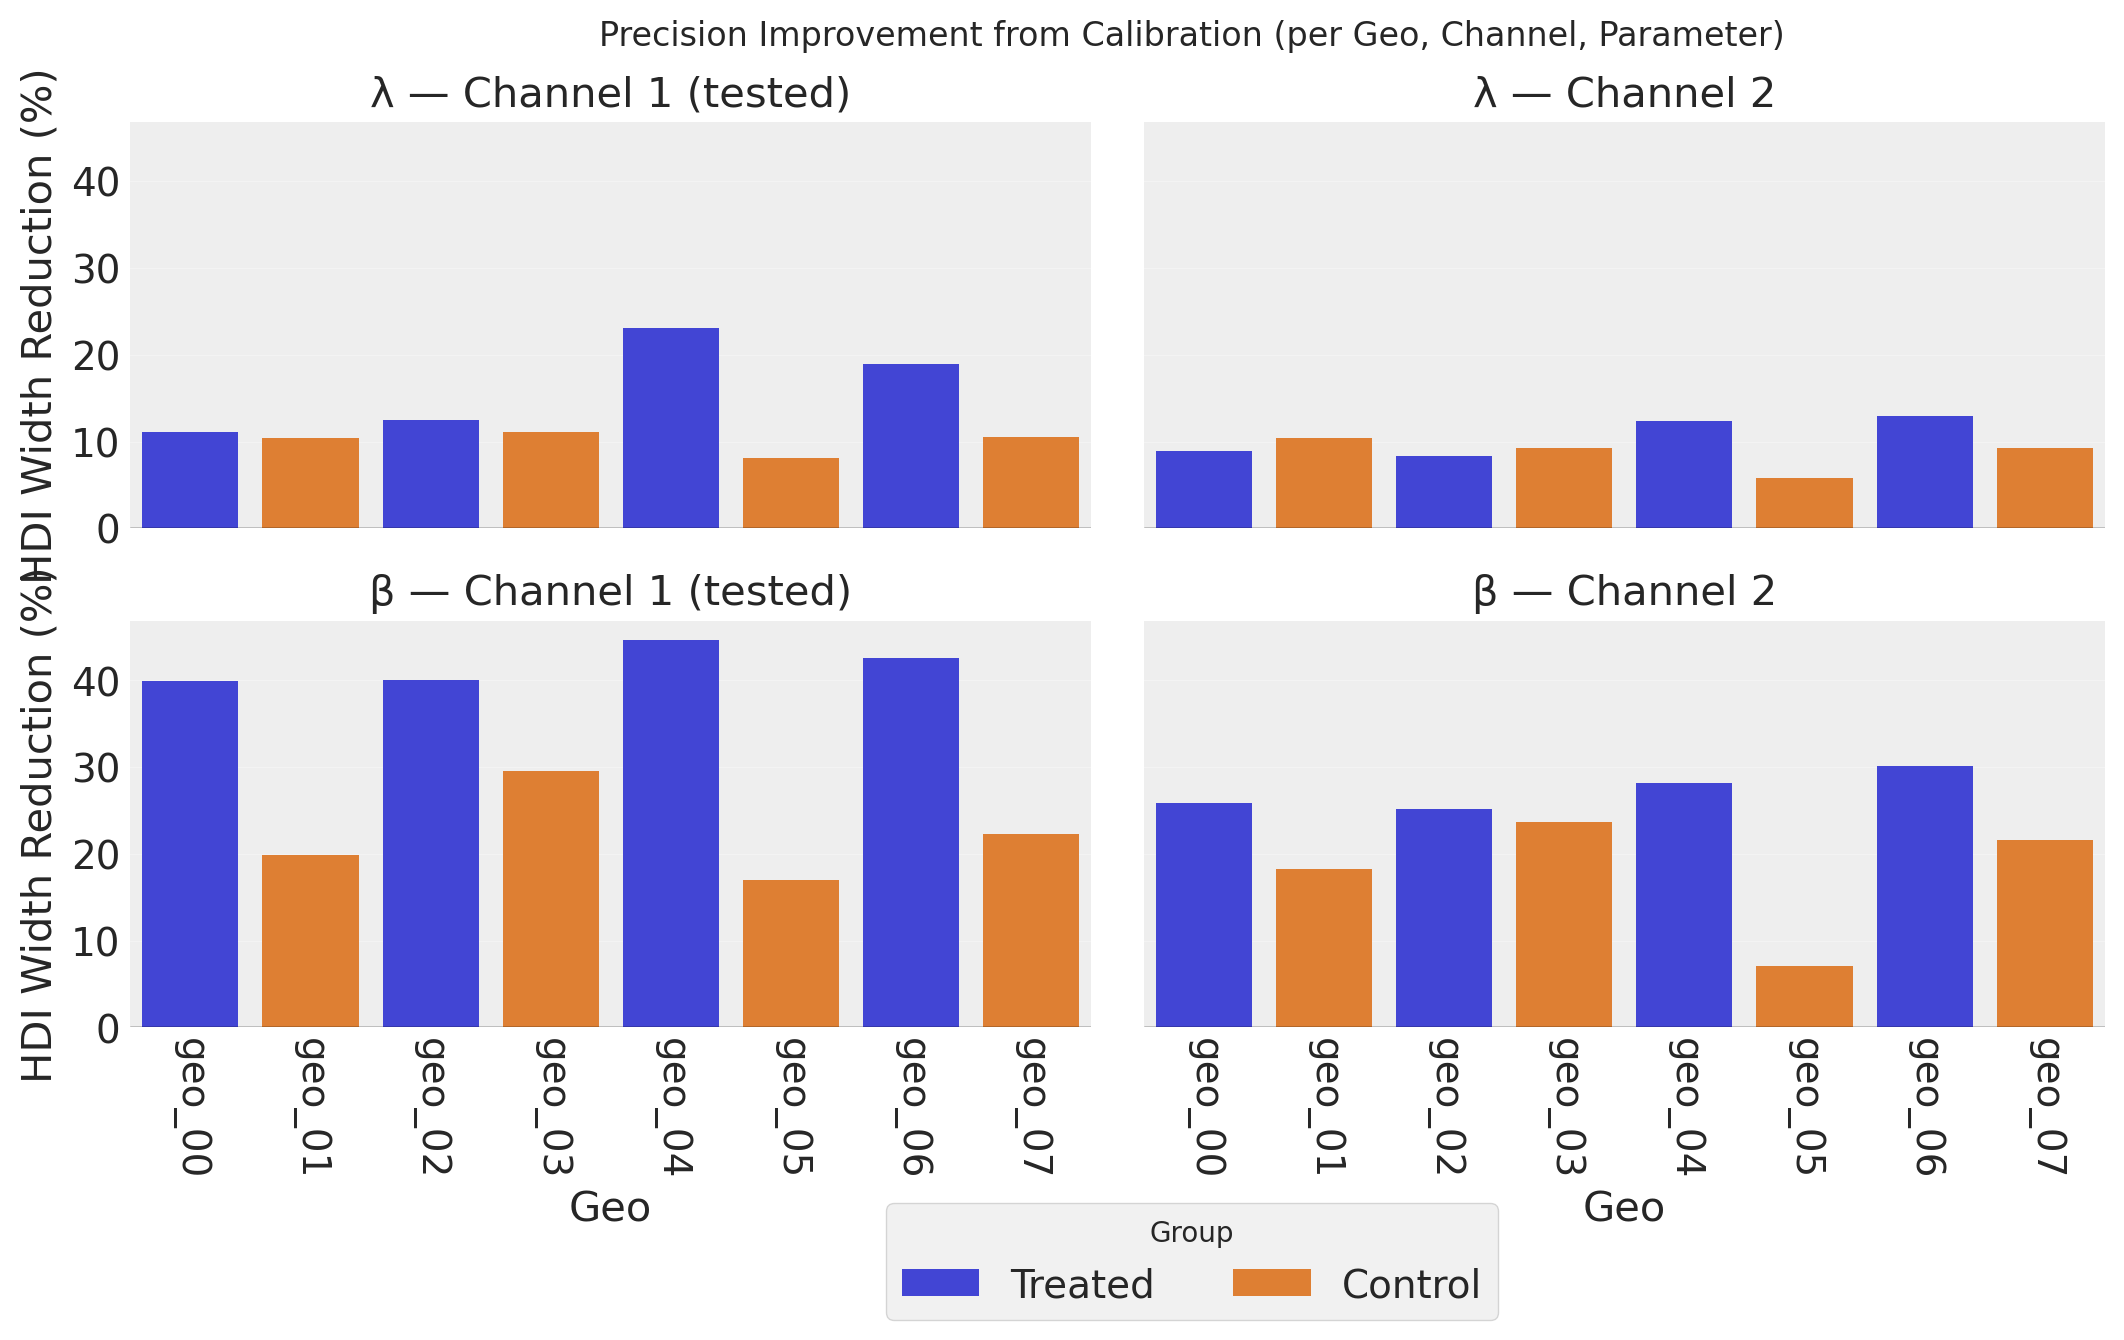

In [29]:
# Build tidy DataFrame: HDI width per (geo, channel, parameter)
import pandas as pd

records = []
for geo_idx, geo in enumerate(geos):
    is_treated = geo in treated_geos
    for ch_idx, _ch_name in enumerate(channels):
        ch_label = f"Channel {ch_idx + 1}" + (" (tested)" if ch_idx == 0 else "")
        for param_name, param_label in [
            ("saturation_lam", "λ"),
            ("saturation_beta", "β"),
        ]:
            samples_uncal = posterior_uncal[param_name][
                :, :, geo_idx, ch_idx
            ].values.flatten()
            samples_cal = posterior_cal[param_name][
                :, :, geo_idx, ch_idx
            ].values.flatten()

            width_uncal = np.diff(az.hdi(samples_uncal, hdi_prob=0.94))[0]
            width_cal = np.diff(az.hdi(samples_cal, hdi_prob=0.94))[0]
            improvement = (width_uncal - width_cal) / width_uncal * 100

            records.append(
                {
                    "geo": geo,
                    "group": "Treated" if is_treated else "Control",
                    "channel": ch_label,
                    "parameter": param_label,
                    "improvement_pct": improvement,
                }
            )

df_precision = pd.DataFrame(records)
print(
    df_precision.pivot_table(
        index=["geo", "group"],
        columns=["parameter", "channel"],
        values="improvement_pct",
    ).to_string()
)

# Faceted bar chart: % HDI width reduction per geo
g = sns.catplot(
    data=df_precision,
    x="geo",
    y="improvement_pct",
    hue="group",
    col="channel",
    row="parameter",
    kind="bar",
    height=3,
    aspect=1.8,
    palette={"Treated": "C0", "Control": "C1"},
    dodge=False,
)
g.set_axis_labels("Geo", "HDI Width Reduction (%)")
g.set_titles("{row_name} — {col_name}")

for ax in g.axes.flat:
    ax.axhline(0, color="black", linewidth=0.5)
    ax.grid(True, alpha=0.3, axis="y")

# Ensure x-tick labels appear on all bottom-row axes
for ax in g.axes[-1, :]:
    ax.tick_params(axis="x", labelbottom=True)
    for label in ax.get_xticklabels():
        label.set_rotation(-90)

# Move legend to bottom, outside the panels
g._legend.remove()
g.figure.legend(
    title="Group",
    loc="lower center",
    ncol=2,
    bbox_to_anchor=(0.5, -0.08),
    frameon=True,
)

g.figure.suptitle(
    "Precision Improvement from Calibration (per Geo, Channel, Parameter)",
    fontsize=12,
    y=1.02,
)
g.figure.subplots_adjust(bottom=0.18)
plt.show()

The bars show the percentage reduction in the 94% HDI width when moving from the uncalibrated to the calibrated model--larger values mean greater precision gains.

The most striking result is in the **bottom-left panel (β, Channel 1)**: both treated and control geos show very large precision gains for the channel weight parameter. This occurs because the lift test directly constrains the saturation curve at the operating point. In the current parameter regime--where channels operate in the dynamic range of the saturation curve rather than deep in saturation--the lift measurement effectively pins down β (the vertical scaling) very tightly. The β precision gains also spill over to Channel 2 (bottom-right) through the hierarchical prior.

**λ (top row)** shows more modest but consistent precision improvements. Because λ governs the *curvature* of the saturation function while the lift test constrains the local *slope* (Δy/Δx), λ benefits less directly than β. Nevertheless, the hierarchical prior structure propagates some precision gains to control geos and to Channel 2 through partial pooling of the population-level parameters.

#### Bias Improvement

We quantify bias improvement by measuring how much the posterior mean moved toward (or away from) the true value, normalized by the uncalibrated posterior width:

$$\text{Bias Improvement (\%)} = \frac{|\bar{\theta}_\text{uncal} - \theta_\text{true}| - |\bar{\theta}_\text{cal} - \theta_\text{true}|}{\text{HDI}_\text{uncal}} \times 100$$

Positive values indicate the calibrated model's posterior mean is closer to the true value. By normalizing with the same denominator as the precision metric (the uncalibrated HDI width), the two plots are directly comparable: both measure changes as a fraction of the original posterior uncertainty.

parameter                       β                            λ          
channel        Channel 1 (tested) Channel 2 Channel 1 (tested) Channel 2
geo    group                                                            
geo_00 Treated          -9.743485  1.872299           1.631204 -0.845052
geo_01 Control          -7.052531  0.276460           1.844731  2.275759
geo_02 Treated          -9.140127  2.375023           0.300784 -0.202236
geo_03 Control          -7.150489  1.474316           1.716305  0.766730
geo_04 Treated          -6.296853 -1.683131           0.878447  0.439332
geo_05 Control          -6.344453 -1.682297           0.022367  2.510126
geo_06 Treated          -7.650816 -1.242571           1.088273 -0.379406
geo_07 Control          -6.673550 -1.969122          -1.829092 -1.353038


/Users/benjamv/mambaforge/envs/pymc-marketing-dev/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


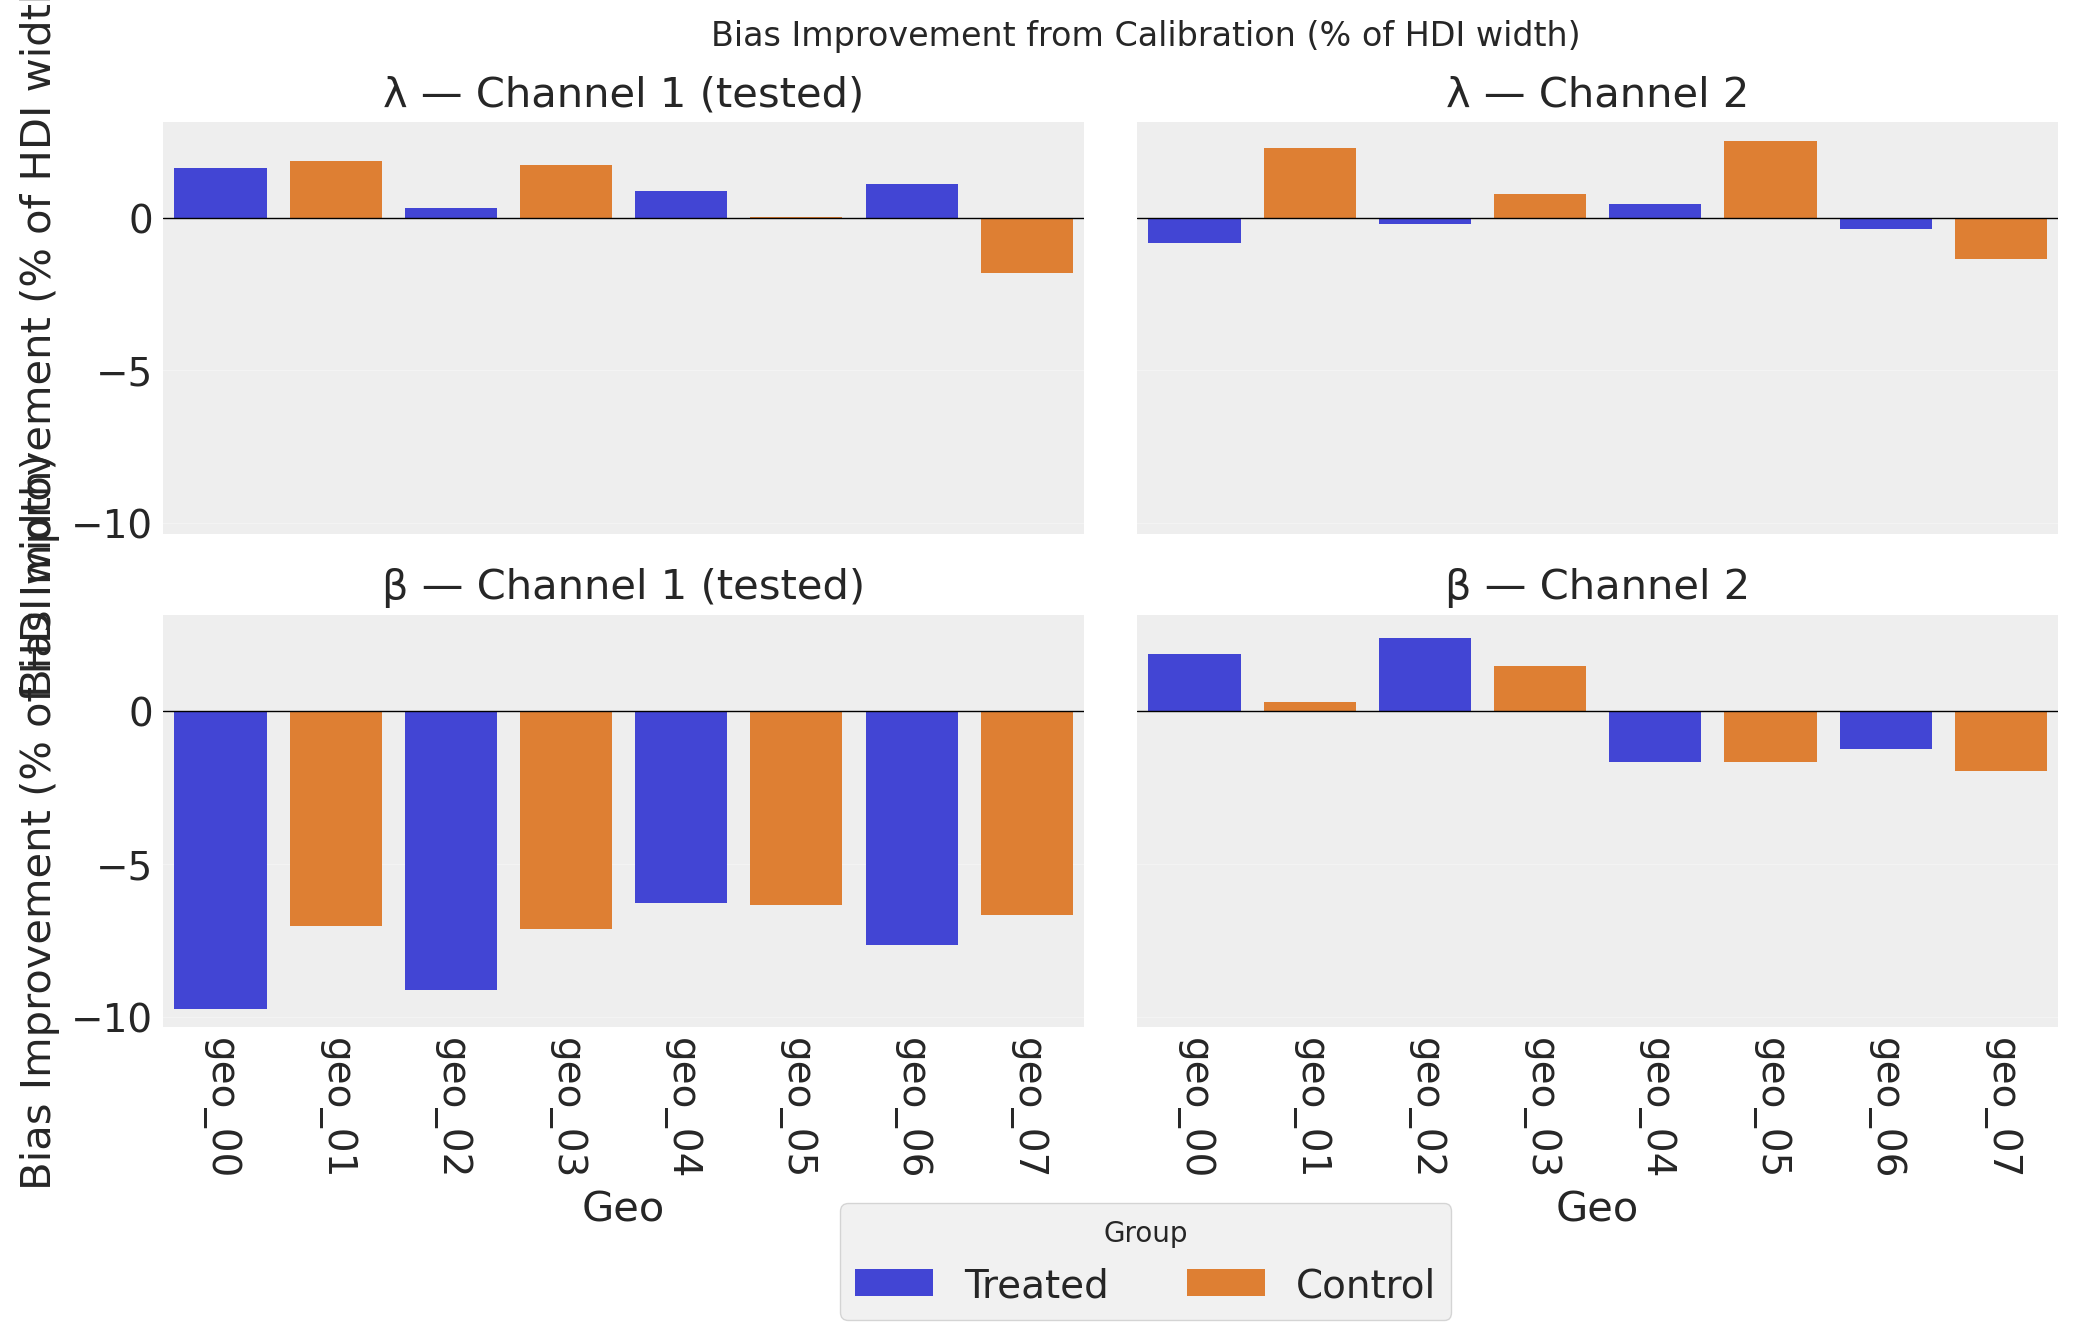

In [30]:
# Build tidy DataFrame: bias reduction per (geo, channel, parameter)
# Bias = |posterior_mean - true_value|

records_bias = []
for geo_idx, geo in enumerate(geos):
    is_treated = geo in treated_geos
    for ch_idx, _ch_name in enumerate(channels):
        ch_label = f"Channel {ch_idx + 1}" + (" (tested)" if ch_idx == 0 else "")
        for param_name, param_label, true_vals in [
            ("saturation_lam", "λ", true_params["saturation_lam"]),
            ("saturation_beta", "β", true_params["saturation_beta"]),
        ]:
            true_val = true_vals[geo_idx, ch_idx]

            samples_uncal = posterior_uncal[param_name][
                :, :, geo_idx, ch_idx
            ].values.flatten()
            samples_cal = posterior_cal[param_name][
                :, :, geo_idx, ch_idx
            ].values.flatten()

            mean_uncal = float(samples_uncal.mean())
            mean_cal = float(samples_cal.mean())

            bias_uncal = abs(mean_uncal - true_val)
            bias_cal = abs(mean_cal - true_val)
            # Normalize by uncalibrated HDI width (same denominator as precision metric)
            hdi_width_uncal = np.diff(az.hdi(samples_uncal, hdi_prob=0.94))[0]
            improvement = (bias_uncal - bias_cal) / hdi_width_uncal * 100

            records_bias.append(
                {
                    "geo": geo,
                    "group": "Treated" if is_treated else "Control",
                    "channel": ch_label,
                    "parameter": param_label,
                    "improvement_pct": improvement,
                }
            )

df_bias = pd.DataFrame(records_bias)
print(
    df_bias.pivot_table(
        index=["geo", "group"],
        columns=["parameter", "channel"],
        values="improvement_pct",
    ).to_string()
)

# Faceted bar chart: % bias reduction per geo
g = sns.catplot(
    data=df_bias,
    x="geo",
    y="improvement_pct",
    hue="group",
    col="channel",
    row="parameter",
    kind="bar",
    height=3,
    aspect=1.8,
    palette={"Treated": "C0", "Control": "C1"},
    dodge=False,
)
g.set_axis_labels("Geo", "Bias Improvement (% of HDI width)")
g.set_titles("{row_name} — {col_name}")

for ax in g.axes.flat:
    ax.axhline(0, color="black", linewidth=0.5)
    ax.grid(True, alpha=0.3, axis="y")

# Ensure x-tick labels appear on all bottom-row axes
for ax in g.axes[-1, :]:
    ax.tick_params(axis="x", labelbottom=True)
    for label in ax.get_xticklabels():
        label.set_rotation(-90)

# Move legend to bottom, outside the panels
g._legend.remove()
g.figure.legend(
    title="Group",
    loc="lower center",
    ncol=2,
    bbox_to_anchor=(0.5, -0.08),
    frameon=True,
)

g.figure.suptitle(
    "Bias Improvement from Calibration (% of HDI width)",
    fontsize=12,
    y=1.02,
)
g.figure.subplots_adjust(bottom=0.18)
plt.show()

The bias improvement plot complements the precision plot above. While precision measures how *tight* the posteriors are, bias improvement measures how much the posterior mean *moved toward the truth*, expressed as a percentage of the uncalibrated HDI width. Using the same denominator as the precision metric makes the two plots directly comparable: both measure changes as a fraction of the original posterior uncertainty. Positive bars indicate the calibrated model's posterior mean is closer to the true value; negative bars indicate a shift away from truth.

**λ (top row)** shows mostly positive bias improvement across geos and channels--the lift test helps the model recover the correct saturation curve shape. However, individual control geos can show modest increases in bias: partial pooling pulls their λ estimates toward the calibrated population mean, which may be further from a particular geo's true value. Because the metric is normalized by the HDI width, these shifts are shown in proper context--a few percent of the posterior width, rather than an alarming raw percentage.

**β, Channel 1 (bottom-left)** shows *uniformly increased* bias across all 8 geos--both treated and control--despite the large precision gains seen in the plot above. This systematic pattern is not a bias-variance tradeoff (the model fit metrics are identical, so there is no prediction-level trade). Instead, it reflects the fact that the lift test constrains a *nonlinear combination* of λ and β ($\beta \cdot [h(\lambda, x+\Delta x) - h(\lambda, x)] \approx \Delta y$): when the posterior concentrates along this constraint surface, the marginal mean for β can shift systematically as it compensates for small λ adjustments. Importantly, the scale of the bars here (~7--10% of HDI width) is modest compared to the precision gains (~40%). The saturation curve recovery plots below confirm this pattern at the functional level: dramatically tighter HDI bands, with posterior mean curves at a similar distance from truth. See the [Conclusion](#understanding-calibration-causal-identification-not-bias-variance-tradeoff) for a deeper discussion of why causal identification--not bias-variance tradeoff--is the correct framing.

Together, the precision and bias plots tell a nuanced story: calibration dramatically tightens posteriors and generally improves accuracy for the saturation curve shape (λ), while the channel weight (β) enjoys large precision gains with a systematic but modest increase in individual parameter bias--a consequence of resolving the causal identification problem under nonlinear parameter coupling.

### Saturation Curve Recovery

A key benefit of lift test calibration is better recovery of the saturation curves. Let's compare the true curves with the inferred curves from both models.

/var/folders/pd/p2qnky2x3xl4w3mgc4lct2200000gn/T/ipykernel_58742/4129859988.py:121: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


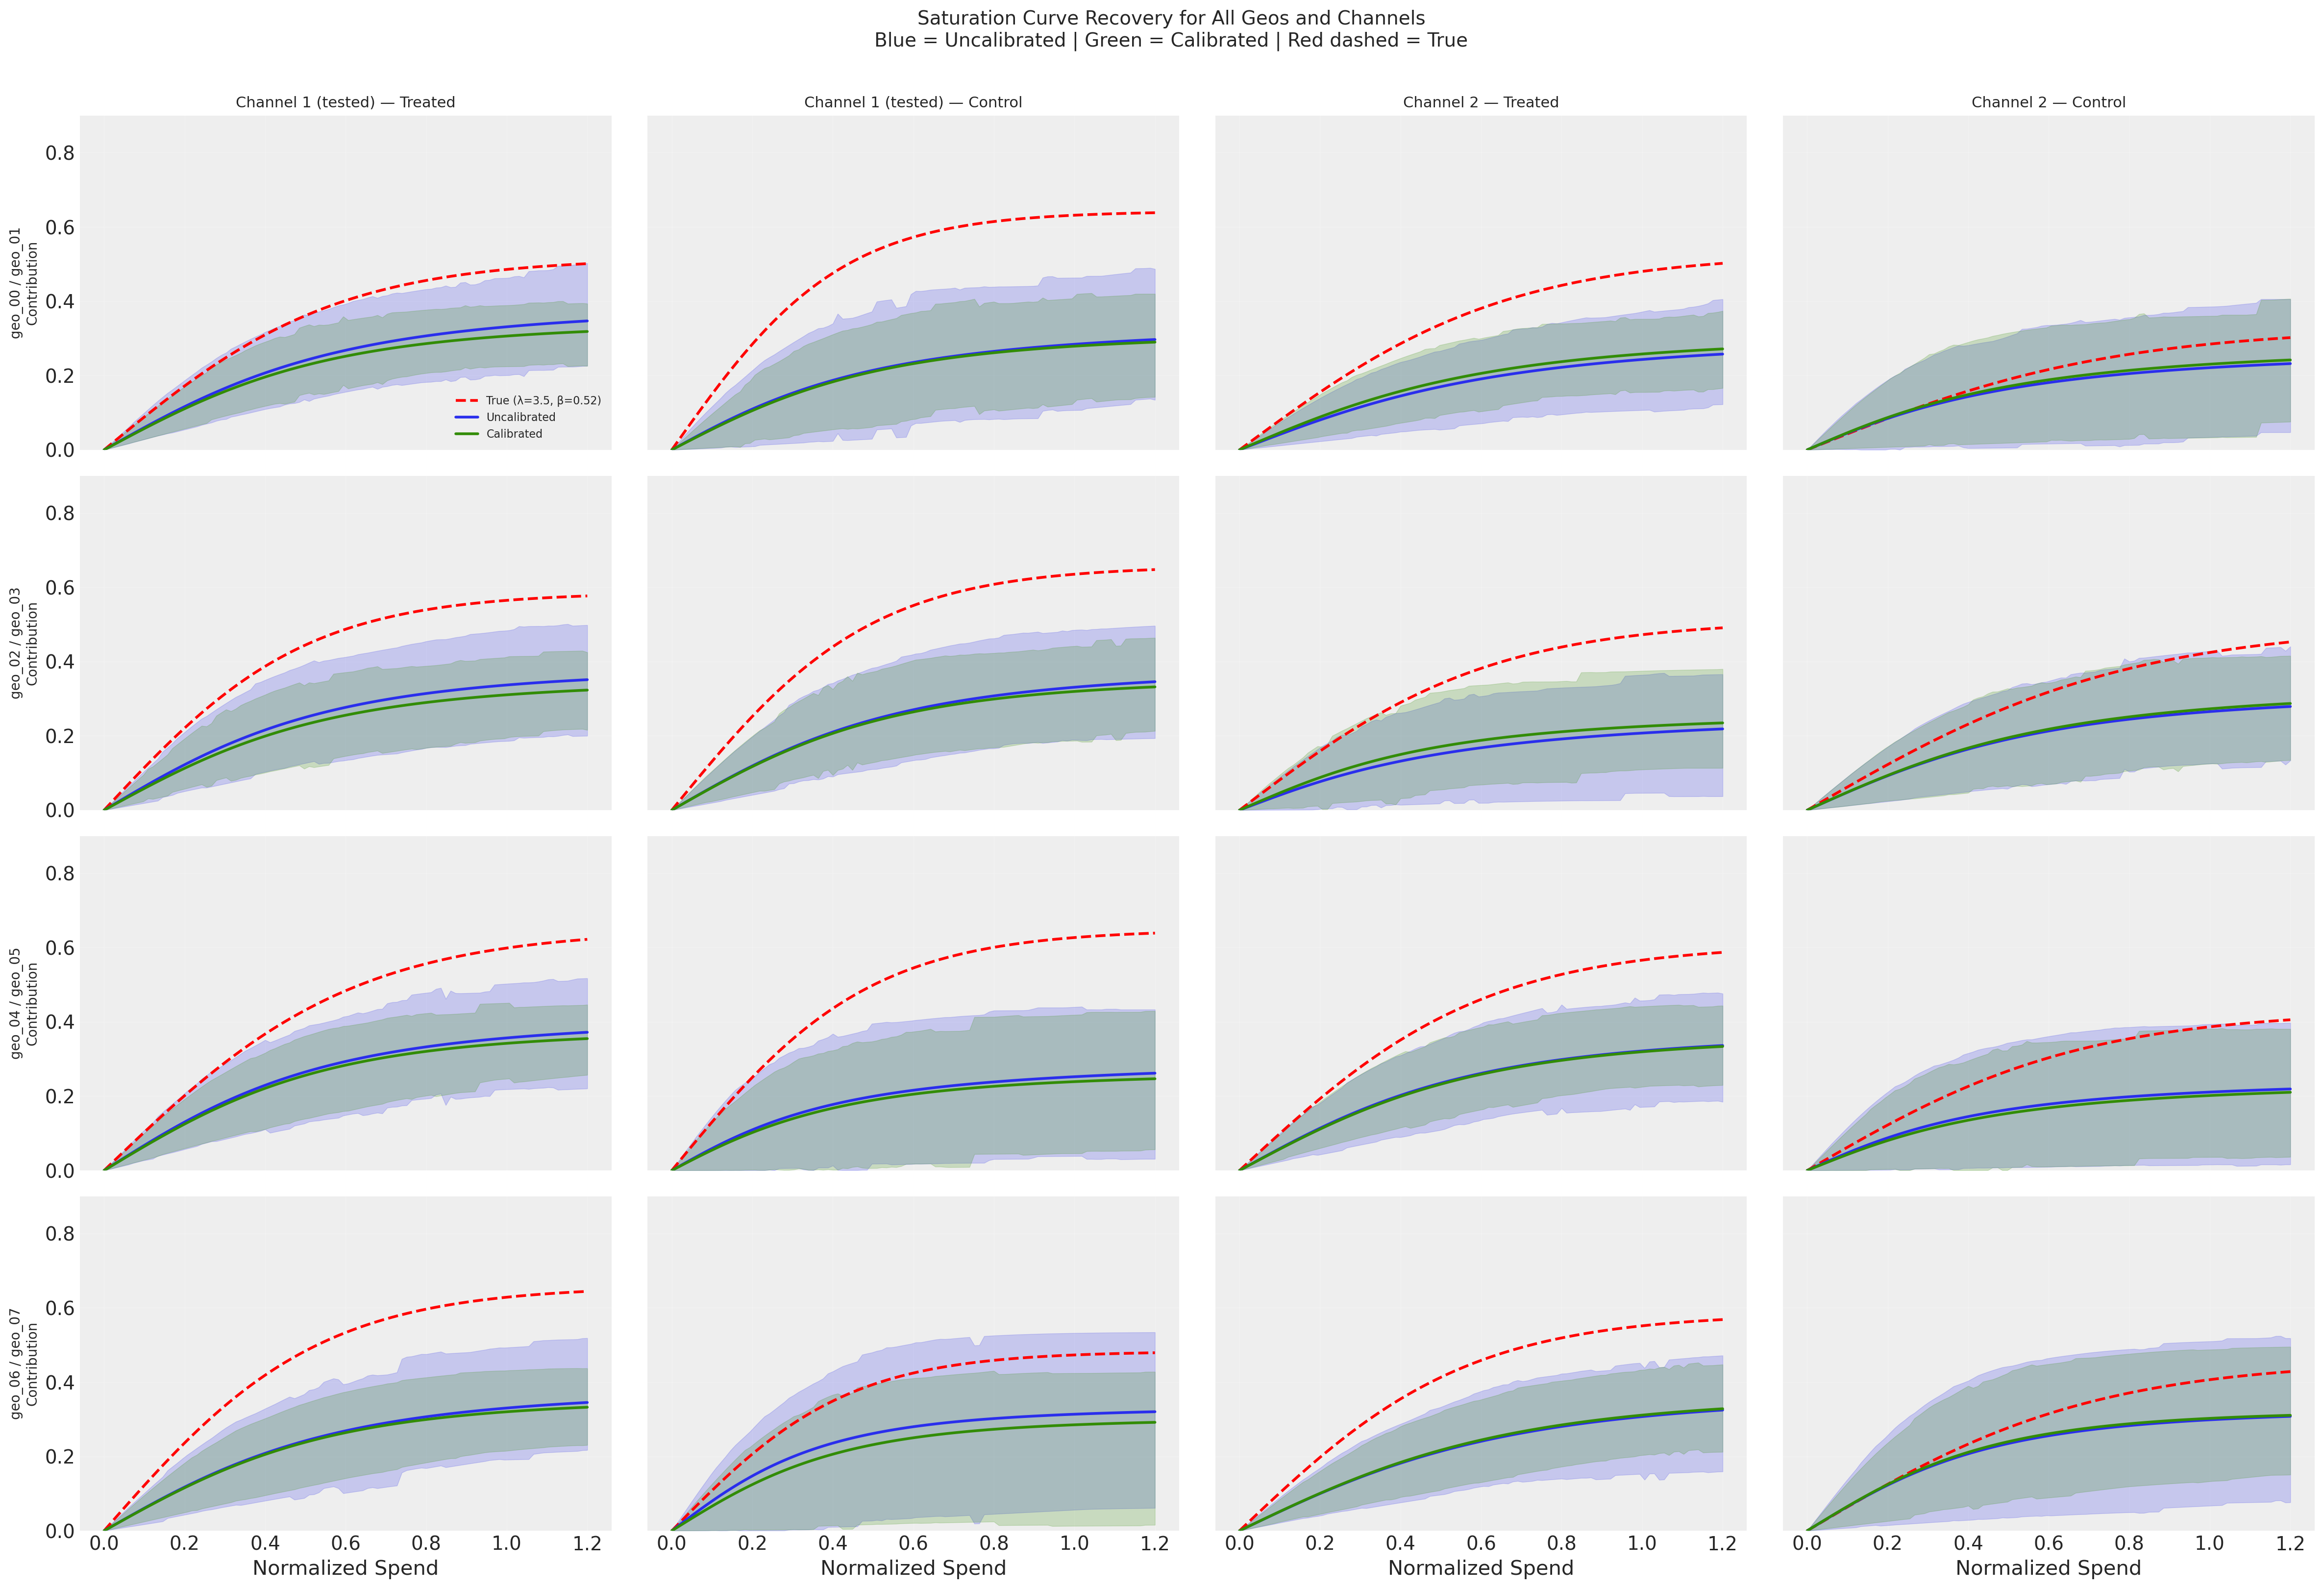

In [31]:
# Plot saturation curve recovery: overlay uncalibrated and calibrated on same axes
# Layout: 4 rows (geo pairs) x 4 columns (Ch1 Treated, Ch1 Control, Ch2 Treated, Ch2 Control)

x_plot = np.linspace(0, 1.2, 100)


def compute_and_plot_curve_hdi(
    ax, lam_samples, beta_samples, x_vals, color, label, hdi_prob=0.94
):
    """Sample saturation curves from posterior and plot HDI bands."""
    n_samples = min(len(lam_samples), 500)
    indices = np.random.choice(len(lam_samples), n_samples, replace=False)
    curves = np.zeros((n_samples, len(x_vals)))
    for i, idx in enumerate(indices):
        curves[i, :] = (
            beta_samples[idx]
            * (1 - np.exp(-lam_samples[idx] * x_vals))
            / (1 + np.exp(-lam_samples[idx] * x_vals))
        )
    mean_curve = np.mean(curves, axis=0)
    az.plot_hdi(
        x_vals,
        curves[np.newaxis, :, :],
        color=color,
        hdi_prob=hdi_prob,
        smooth=False,
        ax=ax,
        fill_kwargs={"alpha": 0.2},
    )
    ax.plot(x_vals, mean_curve, color=color, linewidth=2, label=label)
    return ax


fig, axes = plt.subplots(4, 4, figsize=(24, 16), sharex=True, sharey=True)

# Column layout: Ch1-Treated, Ch1-Control, Ch2-Treated, Ch2-Control
col_configs = [
    (0, "Channel 1 (tested)"),  # ch_idx, label
    (0, "Channel 1 (tested)"),
    (1, "Channel 2"),
    (1, "Channel 2"),
]
group_configs = ["Treated", "Control", "Treated", "Control"]

for row, (treated_geo, control_geo) in enumerate(
    zip(treated_geos, control_geos, strict=True)
):
    for col_idx, (ch_idx, ch_label, group, geo) in enumerate(
        [
            (0, "Channel 1 (tested)", "Treated", treated_geo),
            (0, "Channel 1 (tested)", "Control", control_geo),
            (1, "Channel 2", "Treated", treated_geo),
            (1, "Channel 2", "Control", control_geo),
        ]
    ):
        ax = axes[row, col_idx]
        geo_idx = geos.index(geo)

        # True curve
        true_lam_geo = true_params["saturation_lam"][geo_idx, ch_idx]
        true_beta_geo = true_params["saturation_beta"][geo_idx, ch_idx]
        true_curve = (
            true_beta_geo
            * (1 - np.exp(-true_lam_geo * x_plot))
            / (1 + np.exp(-true_lam_geo * x_plot))
        )
        ax.plot(
            x_plot,
            true_curve,
            "r--",
            linewidth=2,
            label=f"True (λ={true_lam_geo:.1f}, β={true_beta_geo:.2f})",
        )

        # Uncalibrated posterior
        lam_uncal = posterior_uncal["saturation_lam"][
            :, :, geo_idx, ch_idx
        ].values.flatten()
        beta_uncal = posterior_uncal["saturation_beta"][
            :, :, geo_idx, ch_idx
        ].values.flatten()
        compute_and_plot_curve_hdi(
            ax, lam_uncal, beta_uncal, x_plot, color="C0", label="Uncalibrated"
        )

        # Calibrated posterior
        lam_cal = posterior_cal["saturation_lam"][
            :, :, geo_idx, ch_idx
        ].values.flatten()
        beta_cal = posterior_cal["saturation_beta"][
            :, :, geo_idx, ch_idx
        ].values.flatten()
        compute_and_plot_curve_hdi(
            ax, lam_cal, beta_cal, x_plot, color="C2", label="Calibrated"
        )

        ax.set_ylim(0, 0.9)
        ax.grid(True, alpha=0.3)

        # Title: geo name on top row only
        if row == 0:
            ax.set_title(f"{ch_label} — {group}", fontsize=11)

        # Geo label on left margin
        if col_idx == 0:
            ax.set_ylabel(f"{treated_geo} / {control_geo}\nContribution", fontsize=10)

        if row == 3:
            ax.set_xlabel("Normalized Spend")

        # Legend only on first subplot
        if row == 0 and col_idx == 0:
            ax.legend(loc="lower right", fontsize=8)

fig.suptitle(
    "Saturation Curve Recovery for All Geos and Channels\n"
    "Blue = Uncalibrated | Green = Calibrated | Red dashed = True",
    fontsize=14,
    y=1.01,
)
plt.tight_layout()
plt.show()

The overlaid curves make the calibration effect visually clear: the green (calibrated) HDI bands are dramatically tighter than the blue (uncalibrated) bands across all geos---both treated and control, and for both channels. However, the posterior mean curves for both models sit at a similar distance below the true curves (red dashed). Calibration improves **precision** but does not substantially reduce **bias** at the saturation curve level. Comparing the left two columns (Channel 1, tested) with the right two columns (Channel 2, untested) shows that some precision benefit propagates to the untested channel through the hierarchical prior, though the effect is weaker.

**Why is curve recovery so difficult?** There are at least three degeneracies working against the model:

1. **Channel vs channel**: With ~0.99 correlation between channels, the model can freely shift attribution between Channel 1 and Channel 2. The lift test partially resolves this, but only constrains the local slope at the operating point---it does not pin down the global curve level.

2. **Channels vs intercept**: The model predicts y = intercept + channel contributions. It can overestimate the intercept and underestimate both channels' curves (or vice versa). Crucially, the lift test constrains $\Delta y = f(x + \Delta x) - f(x)$, which is a *difference*---it is structurally independent of the intercept. So the lift test **cannot break the intercept-channel degeneracy**, and the systematic underestimation of the curves likely reflects the intercept absorbing some channel contribution.

3. **λ vs β within each channel**: Different combinations of curvature (λ) and scaling (β) can produce similar curves over the observed spend range.

These degeneracies compound: even with a lift test on Channel 1, the model has enough freedom to distribute the total explained variance across intercept + 2 channels in many observationally-equivalent ways. A lift test on one channel for 4 out of 8 geos provides valuable causal information, but it is not sufficient to fully resolve individual channel curves under this level of correlation.

In [32]:
# Generate posterior predictive and compare
mmm_uncalibrated.sample_posterior_predictive(X, extend_idata=True, random_seed=rng)
mmm_calibrated.sample_posterior_predictive(X, extend_idata=True, random_seed=rng)

print("Posterior predictive samples generated")

Sampling: [y]


Output()

Sampling: [lift_measurements, y]


Output()

Posterior predictive samples generated


/var/folders/pd/p2qnky2x3xl4w3mgc4lct2200000gn/T/ipykernel_58742/4062672542.py:97: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


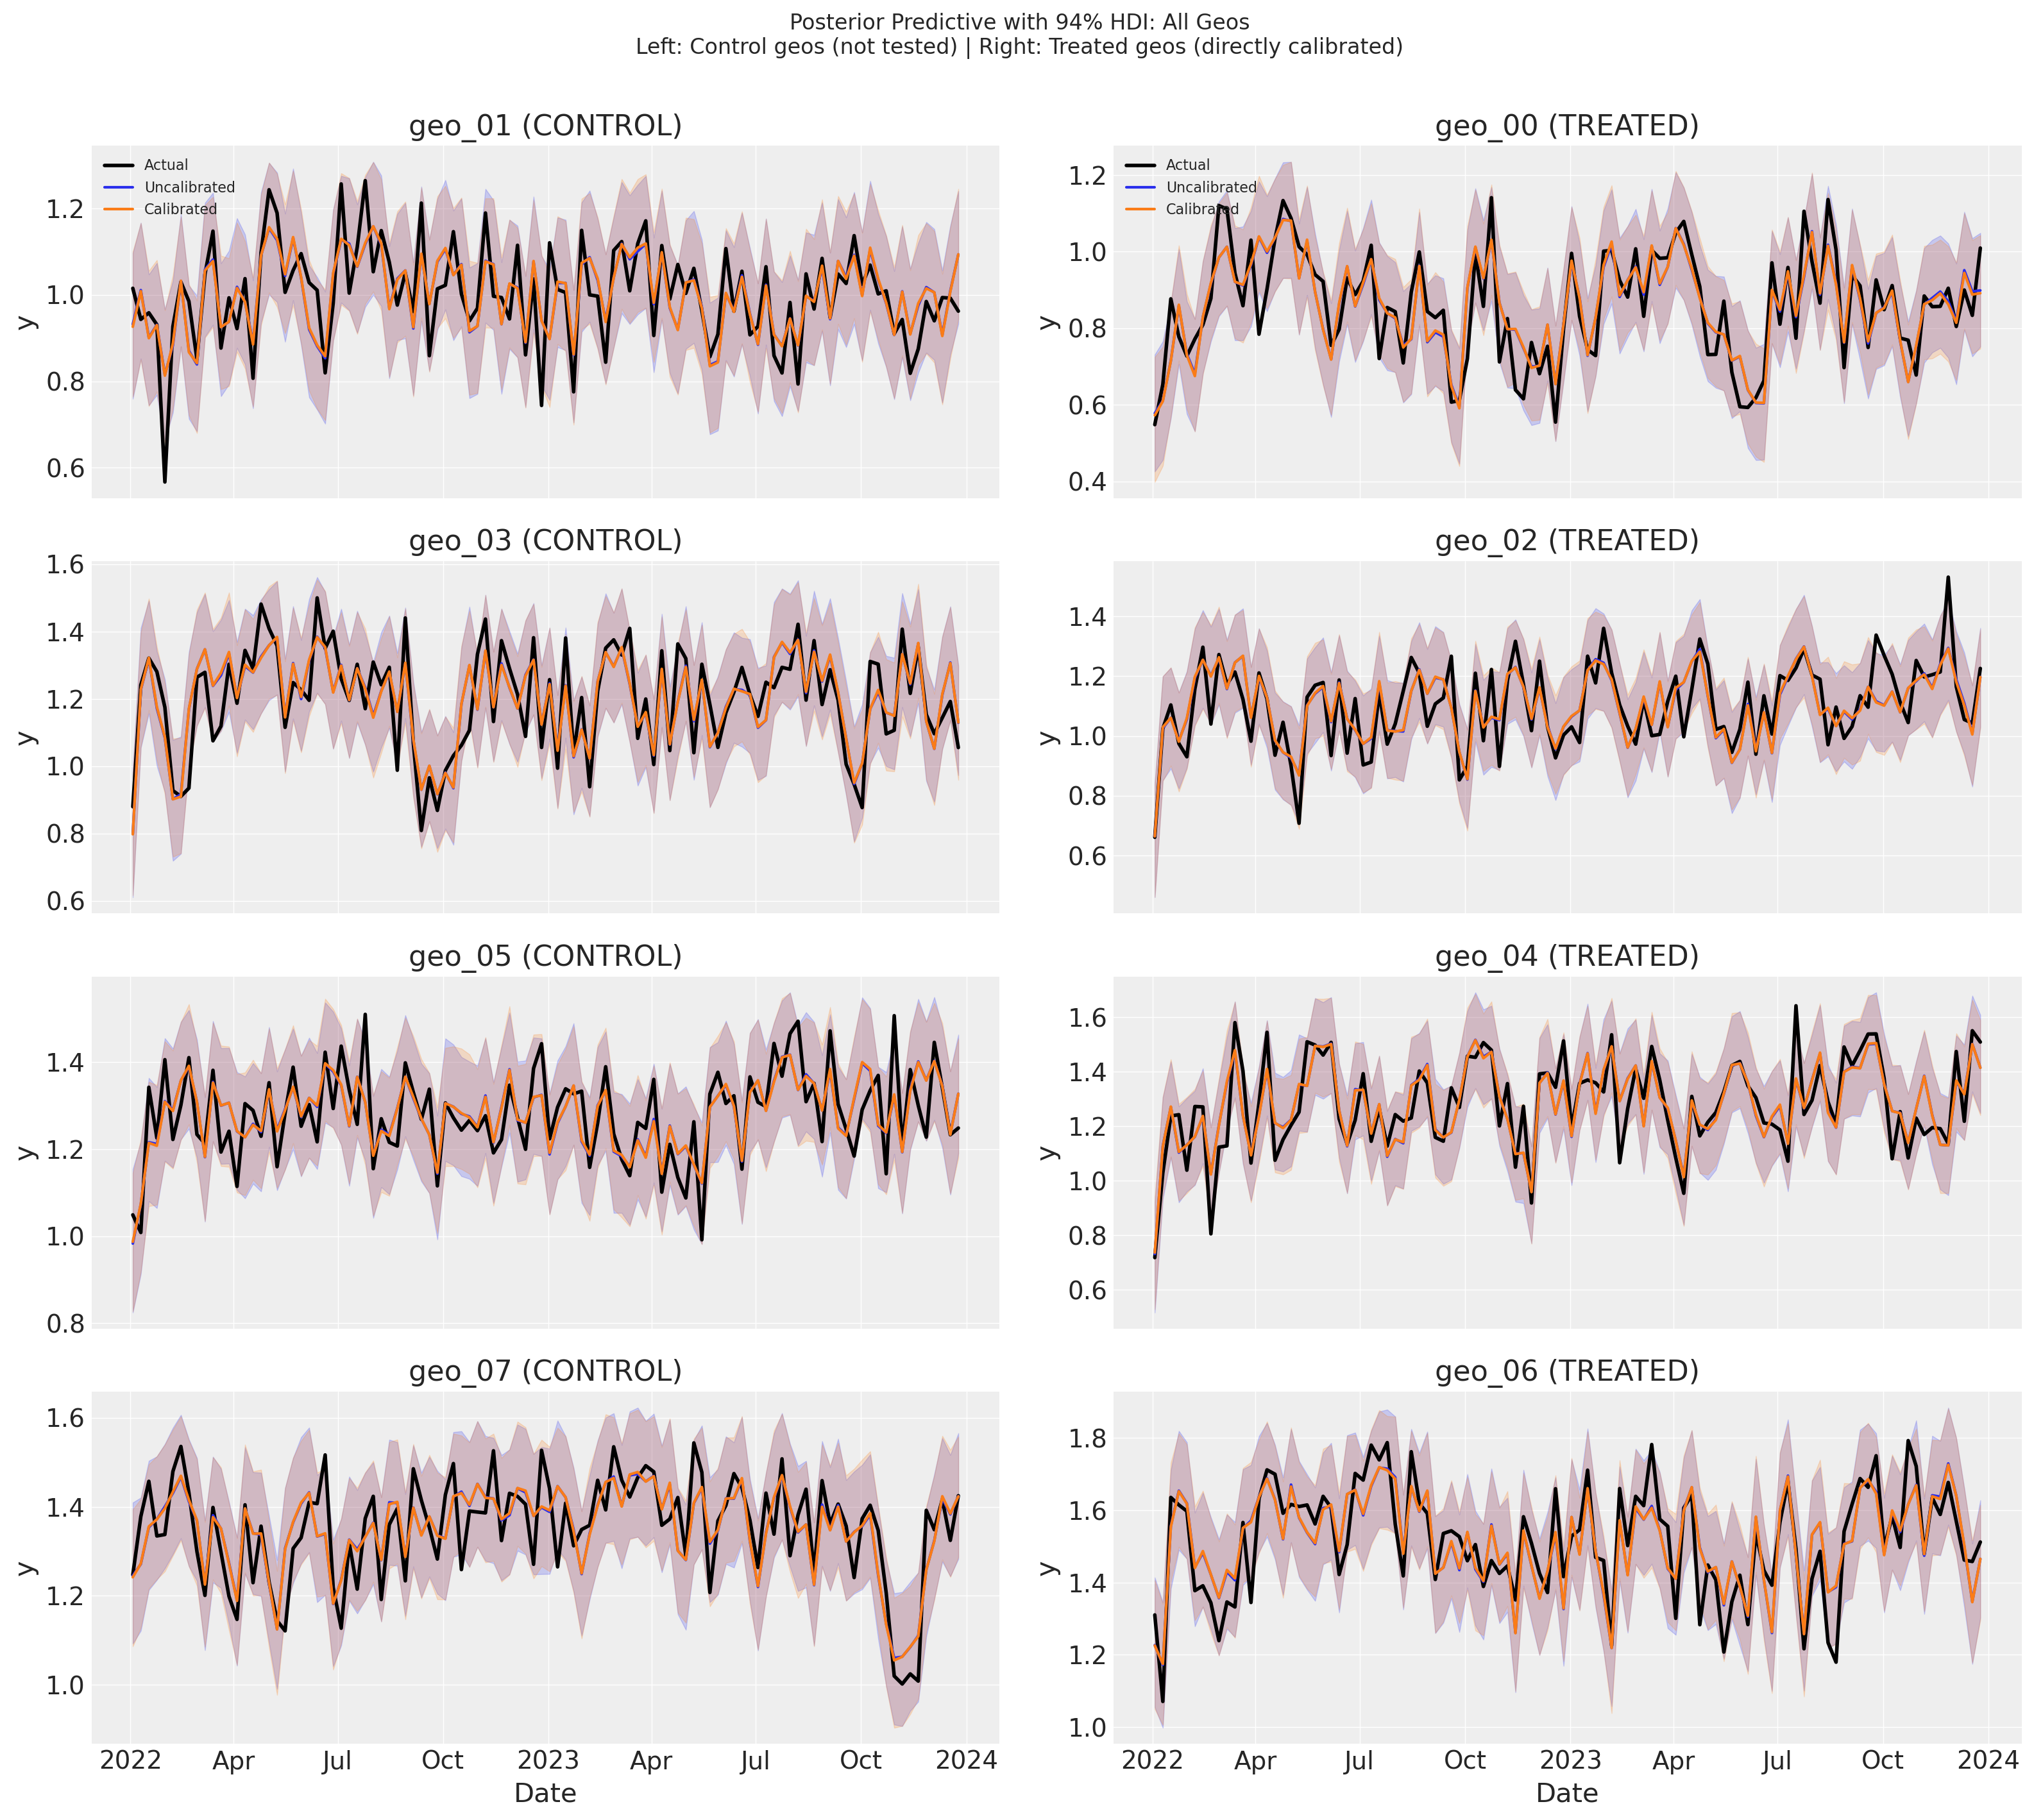


Key observations:
1. TREATED geos (right): Calibrated model (green) should fit better than uncalibrated (blue)
2. CONTROL geos (left): Calibrated model benefits from hierarchical information flow
3. HDI bands show uncertainty - narrower bands indicate more confidence


In [33]:
# Plot predicted vs actual for ALL geos with HDI bands
# Left column: Control geos | Right column: Treated geos
# Each subplot shows: Actual (black) + Uncalibrated pred (blue) + Calibrated pred (green)

# Get full posterior predictive (not just mean) for HDI computation
# Stay in xarray for proper dimension handling
target_scale_uncal = mmm_uncalibrated.get_scales_as_xarray()["target_scale"]
target_scale_cal = mmm_calibrated.get_scales_as_xarray()["target_scale"]

# Scale predictions to original scale (stay in xarray)
pp_uncal = mmm_uncalibrated.idata.posterior_predictive["y"] * target_scale_uncal
pp_cal = mmm_calibrated.idata.posterior_predictive["y"] * target_scale_cal


def plot_predictions_with_hdi(ax, dates, pp_data, color, label, hdi_prob=0.94):
    """Plot predictions with HDI bands."""
    median = pp_data.median(dim=["chain", "draw"])
    az.plot_hdi(
        dates,
        pp_data.values,
        color=color,
        hdi_prob=hdi_prob,
        smooth=False,
        ax=ax,
        fill_kwargs={"alpha": 0.2},
    )
    ax.plot(
        dates, median.values, color=color, linestyle="-", linewidth=1.5, label=label
    )
    return ax


# Create figure: 4 rows x 2 columns
# Left column = Control geos, Right column = Treated geos
fig, axes = plt.subplots(4, 2, figsize=(16, 14), sharex=True)

# Pair control and treated geos for side-by-side comparison
geo_pairs = list(zip(control_geos, treated_geos, strict=True))

for row, (control_geo, treated_geo) in enumerate(geo_pairs):
    # --- Left column: Control geo ---
    ax = axes[row, 0]
    geo_mask = df["geo"] == control_geo
    dates = df.loc[geo_mask, "date"].values
    y_actual = df.loc[geo_mask, "y"].values

    # Plot actual
    ax.plot(dates, y_actual, "k-", linewidth=2, label="Actual")

    # Plot uncalibrated with HDI
    pp_uncal_geo = pp_uncal.sel(geo=control_geo)
    plot_predictions_with_hdi(ax, dates, pp_uncal_geo, "C0", "Uncalibrated")

    # Plot calibrated with HDI
    pp_cal_geo = pp_cal.sel(geo=control_geo)
    plot_predictions_with_hdi(ax, dates, pp_cal_geo, "C1", "Calibrated")

    ax.set_ylabel("y")
    ax.set_title(f"{control_geo} (CONTROL)")
    if row == 0:
        ax.legend(loc="upper left", fontsize=8)
    format_date_axis(ax)

    # --- Right column: Treated geo ---
    ax = axes[row, 1]
    geo_mask = df["geo"] == treated_geo
    dates = df.loc[geo_mask, "date"].values
    y_actual = df.loc[geo_mask, "y"].values

    # Plot actual
    ax.plot(dates, y_actual, "k-", linewidth=2, label="Actual")

    # Plot uncalibrated with HDI
    pp_uncal_geo = pp_uncal.sel(geo=treated_geo)
    plot_predictions_with_hdi(ax, dates, pp_uncal_geo, "C0", "Uncalibrated")

    # Plot calibrated with HDI
    pp_cal_geo = pp_cal.sel(geo=treated_geo)
    plot_predictions_with_hdi(ax, dates, pp_cal_geo, "C1", "Calibrated")

    ax.set_ylabel("y")
    ax.set_title(f"{treated_geo} (TREATED)")
    if row == 0:
        ax.legend(loc="upper left", fontsize=8)
    format_date_axis(ax)

# Set x-axis label only on bottom row
for ax in axes[-1, :]:
    ax.set_xlabel("Date")

plt.suptitle(
    "Posterior Predictive with 94% HDI: All Geos\n"
    "Left: Control geos (not tested) | Right: Treated geos (directly calibrated)",
    fontsize=12,
    y=1.01,
)
plt.tight_layout()
plt.show()

print("\nKey observations:")
print(
    "1. TREATED geos (right): Calibrated model (green) should fit better than uncalibrated (blue)"
)
print(
    "2. CONTROL geos (left): Calibrated model benefits from hierarchical information flow"
)
print("3. HDI bands show uncertainty - narrower bands indicate more confidence")

### Model Fit Comparison

An important consideration when using calibration is whether it improves parameter accuracy without sacrificing overall model fit. Let's compare the in-sample fit metrics (R² and RMSE) for both models.

:::{admonition} Interpreting R² in this context
:class: note

The per-geo R² measures how much within-geo variance in outcomes is explained by channel spend variation over time. Since both models use the same data and differ only in whether lift test constraints are applied, similar R² values are expected—the lift tests primarily improve **parameter accuracy** (recovering the true saturation curves), not predictive fit. The R² is bounded above by the noise-to-signal ratio: higher `y_sigma` or channels operating deep in saturation (where the curve is flat) reduce the explainable variance.
:::

In [34]:
# Compute R² and RMSE for both models
from sklearn.metrics import r2_score, root_mean_squared_error

# Get target scales to convert predictions back to original scale
target_scale_uncal = mmm_uncalibrated.get_scales_as_xarray()["target_scale"]
target_scale_cal = mmm_calibrated.get_scales_as_xarray()["target_scale"]

# Get posterior predictive means (stay in xarray, scale to original)
y_pred_uncal_xa = (
    mmm_uncalibrated.idata.posterior_predictive["y"].mean(dim=["chain", "draw"])
    * target_scale_uncal
)
y_pred_cal_xa = (
    mmm_calibrated.idata.posterior_predictive["y"].mean(dim=["chain", "draw"])
    * target_scale_cal
)

# For overall metrics, compute per-geo R² and RMSE, then average
r2_uncal_list = []
r2_cal_list = []
rmse_uncal_list = []
rmse_cal_list = []

for geo in geos:
    geo_mask = df["geo"] == geo
    y_actual_geo = df.loc[geo_mask, "y"].values
    y_pred_uncal_geo = y_pred_uncal_xa.sel(geo=geo).values
    y_pred_cal_geo = y_pred_cal_xa.sel(geo=geo).values

    r2_uncal_list.append(r2_score(y_actual_geo, y_pred_uncal_geo))
    r2_cal_list.append(r2_score(y_actual_geo, y_pred_cal_geo))
    rmse_uncal_list.append(root_mean_squared_error(y_actual_geo, y_pred_uncal_geo))
    rmse_cal_list.append(root_mean_squared_error(y_actual_geo, y_pred_cal_geo))

# Average across geos
r2_uncal = np.mean(r2_uncal_list)
r2_cal = np.mean(r2_cal_list)
rmse_uncal = np.mean(rmse_uncal_list)
rmse_cal = np.mean(rmse_cal_list)

# Display results
print("Model Fit Comparison (averaged across geos)")
print("=" * 45)
print(f"{'Metric':<15} {'Uncalibrated':>14} {'Calibrated':>14}")
print("-" * 45)
print(f"{'R² (mean)':<15} {r2_uncal:>14.4f} {r2_cal:>14.4f}")
print(f"{'RMSE (mean)':<15} {rmse_uncal:>14.2f} {rmse_cal:>14.2f}")
print("=" * 45)

Model Fit Comparison (averaged across geos)
Metric            Uncalibrated     Calibrated
---------------------------------------------
R² (mean)               0.6494         0.6494
RMSE (mean)               0.08           0.08


## Conclusion

This notebook demonstrated how to calibrate a multidimensional MMM with **geo-varying parameters** using geo-level lift tests and **hierarchical priors**.

### Summary of Results

The key insight is that hierarchical priors enable **information flow** from tested to untested geos:

| Geo Type | Direct Calibration | Indirect Benefit | Result |
|----------|-------------------|------------------|--------|
| **Treated geos** (4) | Yes - lift tests directly constrain parameters | N/A | Strong improvement |
| **Control geos** (4) | No - not tested | Yes - through population parameters | Moderate improvement |
| **Untested channel** | No - only channel 1 was tested | Partial - through geo correlations | Some improvement |




### Key Takeaways

1. **Geo-Level Heterogeneity Matters**:
   - Different geos have different saturation curves (varying λ and β)
   - This is realistic: markets differ in competition, demographics, and maturity
   - Each geo's saturation curve must be recovered separately

2. **Hierarchical Priors Enable Partial Pooling**:
   - Geo-level parameters are drawn from population distributions
   - Lift tests in some geos update the population parameters
   - This propagates information to **all geos**, including untested ones
   - The benefit is stronger for tested geos but extends to the whole model

3. **The Problem**: Without lift tests, highly correlated channels and geo-level variation make parameter recovery difficult

4. **The Solution**: Geo-level lift tests + hierarchical priors:
   - Directly constrain tested geos' saturation curves
   - Indirectly improve untested geos through shared population parameters
   - Result: better parameter recovery across the entire model


### Understanding Calibration: Causal Identification, Not Bias-Variance Tradeoff

Looking at the precision and bias results together with the model fit comparison reveals an important insight about what lift test calibration is actually doing.

**The puzzle**: Calibration consistently improves precision (narrower posteriors) across all parameters, geos, and channels. Yet the bias results for β on Channel 1 show *uniformly increased* bias across all 8 geos. Meanwhile, the model fit metrics (R² and RMSE) are identical for both models. The saturation curve recovery plots confirm the same pattern: dramatically tighter HDI bands, but posterior mean curves that remain at a similar distance from truth. How do we reconcile these observations?

**Why the bias-variance tradeoff doesn't apply here**

It is tempting to invoke the classical bias-variance tradeoff: adding a constraint reduces variance but introduces bias. However, the bias-variance tradeoff applies to **prediction quality**---it trades prediction bias for prediction variance, changing the prediction MSE. Here, predictions are *identical*: the calibrated and uncalibrated models achieve the same R² (0.6494) and RMSE (0.08). There is no tradeoff happening at the prediction level.

This makes sense once we consider the channel correlation (~0.99). With nearly identical channels, the observational likelihood is essentially **flat along a degeneracy direction** in parameter space. Many combinations of (λ₁, β₁, λ₂, β₂) produce the same total predicted y---you can shift contribution from Channel 1 to Channel 2 and get identical predictions. Both models sit on the same likelihood ridge; they simply sit at different locations on it.

**What the lift test is actually doing: resolving causal identification**

The lift test isn't acting like regularization (which would change model fit). It provides **orthogonal, causal information** that the observational data simply cannot supply. It says: "of all the parameter combinations that predict y equally well, *this* is the one that correctly attributes Channel 1's individual contribution."

But "resolving causal identification" is not the same as "perfectly estimating the true parameters." There is an important distinction:

- **Causal identification** means the model can now *distinguish* between parameter sets that attribute sales differently across channels. Without the lift test, the model cannot tell whether Channel 1 or Channel 2 is driving sales---many different attributions fit the data equally well. The lift test breaks this degeneracy.
- **Parameter estimation** is the separate question of how close the resolved estimates land to the true values. Even after breaking the degeneracy, finite noisy data and the nonlinear coupling between λ and β mean the resolved point won't be exact.

In the asymptotic limit (infinite data, perfect measurements), resolving identification would indeed give you both lower bias and higher precision. With finite data, the lift test tells the model *roughly where to look* in the degenerate parameter space, but the specific (λ, β) point it settles on is influenced by the nonlinear constraint surface and the particular noise realization.

| Aspect | Bias-variance tradeoff | Causal identification |
|---|---|---|
| **Prediction quality** | Changes (trades bias for variance) | Unchanged (same R², RMSE) |
| **Why precision improves** | Constraint reduces estimation variance | Causal info eliminates observationally-equivalent alternatives |
| **Why bias can increase** | Deliberate trade for lower variance | Side effect of resolving degeneracy along nonlinear constraint |
| **Information source** | Same data, different estimator | Orthogonal causal information |

**Interpreting the results under this framing**:

- **Precision gains** (~40% for β, Channel 1): The lift test eliminates most observationally-equivalent parameter combinations by providing causal information that the likelihood alone cannot see. The saturation curve recovery plots confirm this: HDI bands are dramatically tighter for the calibrated model across all geos.
- **Unchanged R²/RMSE**: Expected, because the eliminated parameter combinations all predicted y equally well. The lift test resolves a direction the likelihood is blind to.
- **Systematic β bias increase** (~7--10% of HDI width for Channel 1): The lift test constrains a nonlinear combination of λ and β: $\beta \cdot [h(\lambda, x+\Delta x) - h(\lambda, x)] \approx \Delta y$. When the posterior concentrates along this constraint surface, the marginal mean for β can shift systematically as it compensates for small λ adjustments. Because β controls the vertical scaling of the saturation curve, this bias manifests as a consistent vertical offset in the posterior mean curves---visible in the saturation recovery plots, where the calibrated curves sit at roughly the same distance below the true curves as the uncalibrated ones.
- **The uncalibrated model's lower β bias is partly illusory**: The uncalibrated posterior for β is wide---it spans a huge range because the model cannot distinguish the two channels. The posterior mean happens to land near the true β, but not because the model *knows* the true β. It is because the mean of a wide distribution spread along the degeneracy ridge happened to fall close. A wide posterior whose mean is near truth is not the same as a model that has identified the parameter. The calibrated model actually *tries* to pin down β using causal information, and lands slightly off due to the nonlinear coupling. Crucially, the uncalibrated bias metric is **unstable across random seeds**: because the posterior is wide along the degeneracy, the position of its mean is determined by minor asymmetries in the noise realization, not by genuine parameter information. A different random seed would produce a different noise draw, shifting the uncalibrated posterior mean along the ridge---sometimes closer to truth, sometimes further. The calibrated posterior mean, anchored by the lift test, would be far more stable. So the comparison "uncalibrated bias is lower" reflects the luck of this particular seed, not a systematic advantage.

**The bottom line**: Lift test calibration resolves a **causal identification problem** that observational data alone cannot solve, regardless of sample size. The primary benefit is dramatic precision improvement---the model moves from "I have no idea which channel is driving sales" to "I can meaningfully distinguish the two channels." The modest bias increase in β is the cost of actually attempting this identification with finite, noisy data and a nonlinear saturation function.

### Attribution vs Saturation Positioning: What Calibration Can and Cannot Do

The saturation curve recovery plots paint a sobering picture: even after calibration, the posterior mean curves sit well below the true curves. But this doesn't mean calibration has failed---it means we need to distinguish between two different things practitioners want from an MMM.

**Attribution** asks: "How much of my sales come from Channel 1?" This requires knowing β (the absolute level of the saturation curve). The intercept-channel degeneracy undermines this: the model can overestimate the intercept and underestimate both channels' curves without changing its predictions. The lift test cannot break this degeneracy because it constrains $\Delta y = f(x + \Delta x) - f(x)$, a difference that is independent of the intercept.

**Saturation positioning** asks: "Am I near saturation on Channel 1? Would an extra dollar of spend yield a high or low marginal return?" This is primarily about λ (the curvature of the saturation function). If you know λ with good precision, you know whether you are on the steep part of the curve (high marginal return, far from saturation) or the flat part (low marginal return, near saturation). And we *do* see meaningful precision improvements on λ (~8--23%).

These two questions are affected differently by the degeneracy:

| Question | Key parameter | Affected by intercept degeneracy? | Calibration helps? |
|---|---|---|---|
| **Attribution**: "How much does Channel 1 contribute?" | β (absolute level) | Yes---intercept absorbs contribution | Limited---cannot break this degeneracy |
| **Saturation positioning**: "Am I near saturation?" | λ (curvature) | No---curvature is independent of intercept | Yes---precision improves 8--23% |
| **Local marginal return**: "What is my current ROI?" | β $\cdot$ h'(λ, x) at operating point | Partially | Yes---directly constrained by lift test |

The lift test directly measures the local marginal return at the operating point ($\Delta y / \Delta x$), and the λ precision improvement tells you how quickly that marginal return changes as you move away from the operating point. Together, these are exactly what you need for within-channel spend optimization---"given my current spend level, should I increase or decrease?"---even without resolving the absolute attribution.

**The practical takeaway**: calibration may not fully solve the attribution problem under extreme channel correlation, but it *does* provide the tools for better marginal spending decisions. When saturation curves look poorly recovered in absolute terms, check whether the curvature (λ) is well-estimated---that is often what matters most for budget optimization.


### What This Means for Practitioners

When designing geo-level experiments:
- **You don't need to test every geo** - hierarchical structure shares information
- **More tested geos = better population estimates** - but diminishing returns
- **Strategic selection matters** - test geos that represent the population well
- **Both channels benefit** - even untested channel 2 improves through correlations



### Practical Application

In practice:
1. **Design geo-level experiments** with treated and control regions
2. **Conduct experiments** with increased (or decreased) spend on target channel
3. **Analyze with CausalPy** using synthetic control to get lift estimates (`delta_y`, `sigma`)
4. **Format as DataFrame** with columns: `[channel, geo, x, delta_x, delta_y, sigma]`
5. **Use hierarchical priors** for saturation parameters (as shown in this notebook)
6. **Add lift tests to MMM**: `mmm.add_lift_test_measurements(df_lift_test)`

### Implementation Notes

**Spend normalization during experiments**: In this notebook, treated geos received increased spend during the experiment period, which caused channel 1 values to slightly exceed the typical [0, 1] normalized range (up to ~1.15). This is realistic—experiments often involve spend levels outside normal operating ranges to generate measurable lift. When applying this approach:

- **Saturation curves remain valid** beyond x=1.0; the logistic function is defined for all positive values
- **Interpretation shifts**: values above 1.0 represent spend levels higher than the historical maximum used for normalization
- **Consider your priors**: ensure saturation priors (especially `lam`) are appropriate for the extended range—curves should still exhibit reasonable behavior at experiment spend levels
- **Alternative approach**: you could re-normalize including experiment data, but this changes the interpretation of all historical spend values

### References

- [CausalPy Multi-Cell GeoLift](https://causalpy.readthedocs.io/en/latest/notebooks/multi_cell_geolift.html) - for synthetic control analysis
- [PyMC-Marketing National-Level Lift Tests](mmm_lift_test.ipynb) - simpler single-geo case
- [PyMC-Marketing Multidimensional MMM](mmm_multidimensional_example.ipynb) - geo-level modeling basics
- [Model Configuration Guide](../general/model_configuration.ipynb) - hierarchical prior specification